In [1]:
import matplotlib.pyplot as plt
plt.style.use("../styles/hda.mplstyle")

(chp-topic-models)=
# A Topic Model of United States Supreme Court Opinions, 1900--2000

(sec-topic-models-introduction)=
## Introduction

<!-- what -->

In this chapter we will use an unsupervised model of text---a <span class="index">mixed-membership model</span> or "<span class="index">topic
model</span>"---to make visible trends in the texts of decisions issued by the United States Supreme Court.
Like many national courts, the decisions issued by the Court tend to deal with subjects which can be
grouped into a handful of categories such as contract law, criminal procedure, civil rights,
interstate relations, and due process. Depending on the decade, the Court issues decisions related
to these areas of law at starkly different rates. For example, decisions related to criminal
procedure (e.g., rules concerning admissible evidence and acceptable police practices) were common
in the 1970s and 1980s but rare today. Maritime law, as one might anticipate, figured in far more
cases before 1950 than it does now. A topic model can be used to make these trends visible.

<!-- why -->

```{margin}
Prominent commercial providers of
discrete labels for legal texts include Westlaw (owned by Thompson Reuters) and LexisNexis (owned by
RELX Group, né Elsevier).
```
This exploration of trends serves primarily to illustrate the effectiveness of an unsupervised
method for labeling texts.  Labeling what areas of law are discussed in a given Supreme Court
decision has historically required the involvement of legal experts. As legal experts are typically
costly to retain, these labels are expensive. More importantly perhaps, the process by which these
labels are arrived at is opaque to non-experts and to experts other than those doing the labeling.
Being able to roughly identify the subject(s) discussed in a decision without manually labeled texts
has, therefore, considerable attraction to scholars in the field.

<!-- how -->

This chapter describes how a <span class="index">mixed-membership model</span> can roughly identify the subject(s) of decisions
without direct supervision or labeling by human readers.  To give some sense of where we are headed,
consider {numref}`fig-topic-models-discrimination-topic` below, which shows for each year
between 1903 and 2008 the proportion of all words in opinions related to a "topic"
characterized by the frequent occurrence of words such as *school*, *race*, *voting*,
*education*, and *minority*. (The way the model identifies these particular words is described in
section {ref}`sec-topic-models-parameter-estimation`.) Those familiar with United States history will
not be surprised to see that the number of decisions associated (in a manner to be described
shortly) with this constellation of frequently co-occurring words (*school*, *race*, *voting*,
*education*, and *minority*) increases dramatically in the late 1950s. The orange vertical line
shows the year 1954, the year of the decision *Brown v. Board of Education of Topeka* (347 U.S.
483). This decision ruled that a school district (the governmental entity responsible for education
in a region of a US state) may not establish separate schools for black and white students. *Brown
v. Board of Education of Topeka* was one among several decisions related to minorities' civil rights
and voting rights: the 1960s and the 1970s witnessed multiple legal challenges to two signature laws
addressing concerns at the heart of the civil rights movement in the United States: the Civil Rights
Act of 1964 and the Voting Rights Act of 1965.

```{figure} figures/discrimination-topic.png
---
name: fig-topic-models-discrimination-topic
width: 70%
---

Vertical line shows the year 1954, the year of the decision *Brown v. Board of Education
of Topeka* (347 U.S. 483).
```

```{note}
An example of a challenge to the Voting Rights Act brought by a white-majority state government is *South Carolina v. Katzenbach* (383 U.S. 301). In *South Carolina v. Katzenbach*, South Carolina argued that a provision of the Voting Rights Act violated the state's right to regulate its own elections. Prior to the Voting Rights Act, states such as South Carolina had exercised their "rights" by discouraging or otherwise blocking non-whites from voting through literacy tests and poll taxes. In 2013, five Republican-appointed judges on the Supreme Court weakened an essential provision of the Voting Rights Act, paving the way for the return of voter discouragement measures in states such as Georgia {cite:p}`williams2018georgia`.
```

To understand how an unsupervised, <span class="index">mixed-membership model</span> of Supreme Court opinions permits us to identify both
semantically related groupings of words and trends in the prevalence of these groupings over time, we
start by introducing a simpler class of unsupervised models which are an essential building
block in the mixed-membership model: the <span class="index">mixture model</span>. After introducing the mixture model we will
turn to the mixed-membership model of text data, the model colloquially known as a topic model. By
the end of the chapter, you should have learned enough about topic models to use one to model any large text corpus.

In [2]:
# HIDE THIS CELL
# NOTE: fixed random seed for normal mixture model
import numpy.random; numpy.random.seed(1)
import random; random.seed(1)

(sec-topic-models-mixture-models)=
## Mixture Models: Artwork Dimensions in the Tate Galleries

A <span class="index">mixture model</span> is the paradigmatic example of an <span class="index">*unsupervised model*</span>. Unsupervised models, as the
name indicates, are not supervised models. Supervised models, such as nearest neighbors classifiers
(cf. chapter {ref}`chp-vector-space-model` and {ref}`chp-stylometry`) or logistic regression,
"learn" to make correct predictions in the context of labeled examples and a formal description of a
decision rule. They are, in this particular sense, supervised. These supervised models are typically evaluated in terms of the predictions they make: give them
an input and they'll produce an output or a distribution over outputs. For example, if we have a model which
predicts the genre (tragedy, comedy, or tragicomedy) of a seventeenth century French play, the input we
provide the model is the text of the play and the output is a genre label or a probability
distribution over labels. If we were to give as input the text of Pierre Corneille's *Le Cid*
(1636), the model might predict tragedy with probability 10 percent, comedy with 20 percent, and
tragicomedy with 70 percent. *Le Cid* is traditionally classified as a tragicomedy (cf.
chapter {ref}`chp-vector-space-model`).

Unsupervised models, by contrast, do not involve decision rules that depend on labeled data.
Unsupervised models make a wager that patterns in the data are sufficiently strong that different
latent classes of observations will make themselves "visible".  (This is also the general intuition
behind cluster analysis (see section {ref}`sec-stylometry-hierarchical-clustering`).) We will make
this idea concrete with an example. The classic unsupervised model is the normal (or Gaussian) *mixture model* and a typical setting for this model is when one has <span class="index">multi-modal</span> data. In this section we estimate the parameters of a normal mixture model using
observations of the dimensions of ca. 63,000 two-dimensional artworks in four art museums in the United Kingdom. Doing so will not take us far from topic
modeling---mixtures of normal distributions appear in many varieties of topic models---and should
make clear what we mean by an unsupervised model.

We start our analysis by verifying that the dimensions of artworks from the four museums
(the Tate galleries) are conspiciously multimodal. First, we need to load the data. A CSV
file containing metadata describing artworks is stored in the `data` folder in compressed
form `tate.csv.gz`. We load it and inspect the first two records with the following lines of
code:

In [3]:
import pandas as pd

df = pd.read_csv("data/tate.csv.gz", index_col='artId')
df[["artist", "acquisitionYear", "accession_number", "medium", "width", "height"]].head(2)

artist  acquisitionYear accession_number  \
artId                                                    
1035   Blake, Robert           1922.0           A00001   
1036   Blake, Robert           1922.0           A00002   

                                                  medium  width  height  
artId                                                                    
1035   Watercolour, ink, chalk and graphite on paper....    419     394  
1036                                   Graphite on paper    213     311

In [4]:
# HIDE THIS CELL
assert df.shape[0] == 63298, df.shape[0]

```{margin}
As of this writing, this work can be viewed at <https://www.tate.org.uk/art/artworks/blake-a-figure-bowing-before-a-seated-old-man-with-his-arm-outstretched-in-benediction-a00001>. <!-- https://web.archive.org/web/20171214061341/https://www.tate.org.uk/art/artworks/blake-a-figure-bowing-before-a-seated-old-man-with-his-arm-outstretched-in-benediction-a00001 -->
```
Here we can see that the first entries are associated with Robert Blake (1762–-1787). The first entry is an artwork composed using watercolors, ink, chalk, and graphite on paper. It is 419 millimeters wide and 394 millimeters tall.

Before continuing, we will filter out 18 records which would otherwise challenge our model and make visualization more difficult. The vast majority of records in the dataset concern sketches, drawings, and paintings of modest size. (The 99th percentile of `width` is about 2 meters.) The dataset does, however, include several gigantic pieces making use of materials such as aluminum, steel, and marble. The first line of code below restricts our analysis to art objects which are less than 8 meters wide and less than 8 meters tall, filtering out all of these gigantic pieces. The second line of code restricts our analysis to art objects which are at least 20 mm wide and at least 20 mm tall. This serves to filter out artworks where depth may have been mistakenly recorded as height or width.

In [5]:
df = df.loc[(df['width'] < 8000) & (df['height'] < 8000)]
df = df.loc[(df['width'] >= 20) & (df['height'] >= 20)]

In [6]:
# HIDE THIS CELL
assert df.shape[0] == (63298 - 18), df.shape[0]

Because we will be using normal distributions to model the data, we will take the logarithm (base 10) of the measurements as this will make the suggestion, implied by our use of the model, that each observation is generated from a normal distribution considerably more plausible. The cost of this transformation is modest: we will have to remember that our values are on the log scale, with 2 being equal to 100 mm, 3 being equal to 1000 mm, and so on.

In [7]:
import numpy as np

df["width_log10"] = np.log10(df["width"])
df["height_log10"] = np.log10(df["height"])

To gain a sense of the distribution of widths and heights across all of the artworks in our version of the dataset, we use the following block of code to produce smoothed histograms ("kernel density estimates") of these two features using all of the records. These histograms are shown below:

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


findfont: Generic family 'sans-serif' not found because none of the following families were found: "Roboto Condensed Regular"


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


findfont: Generic family 'sans-serif' not found because none of the following families were found: "Roboto Condensed Regular"


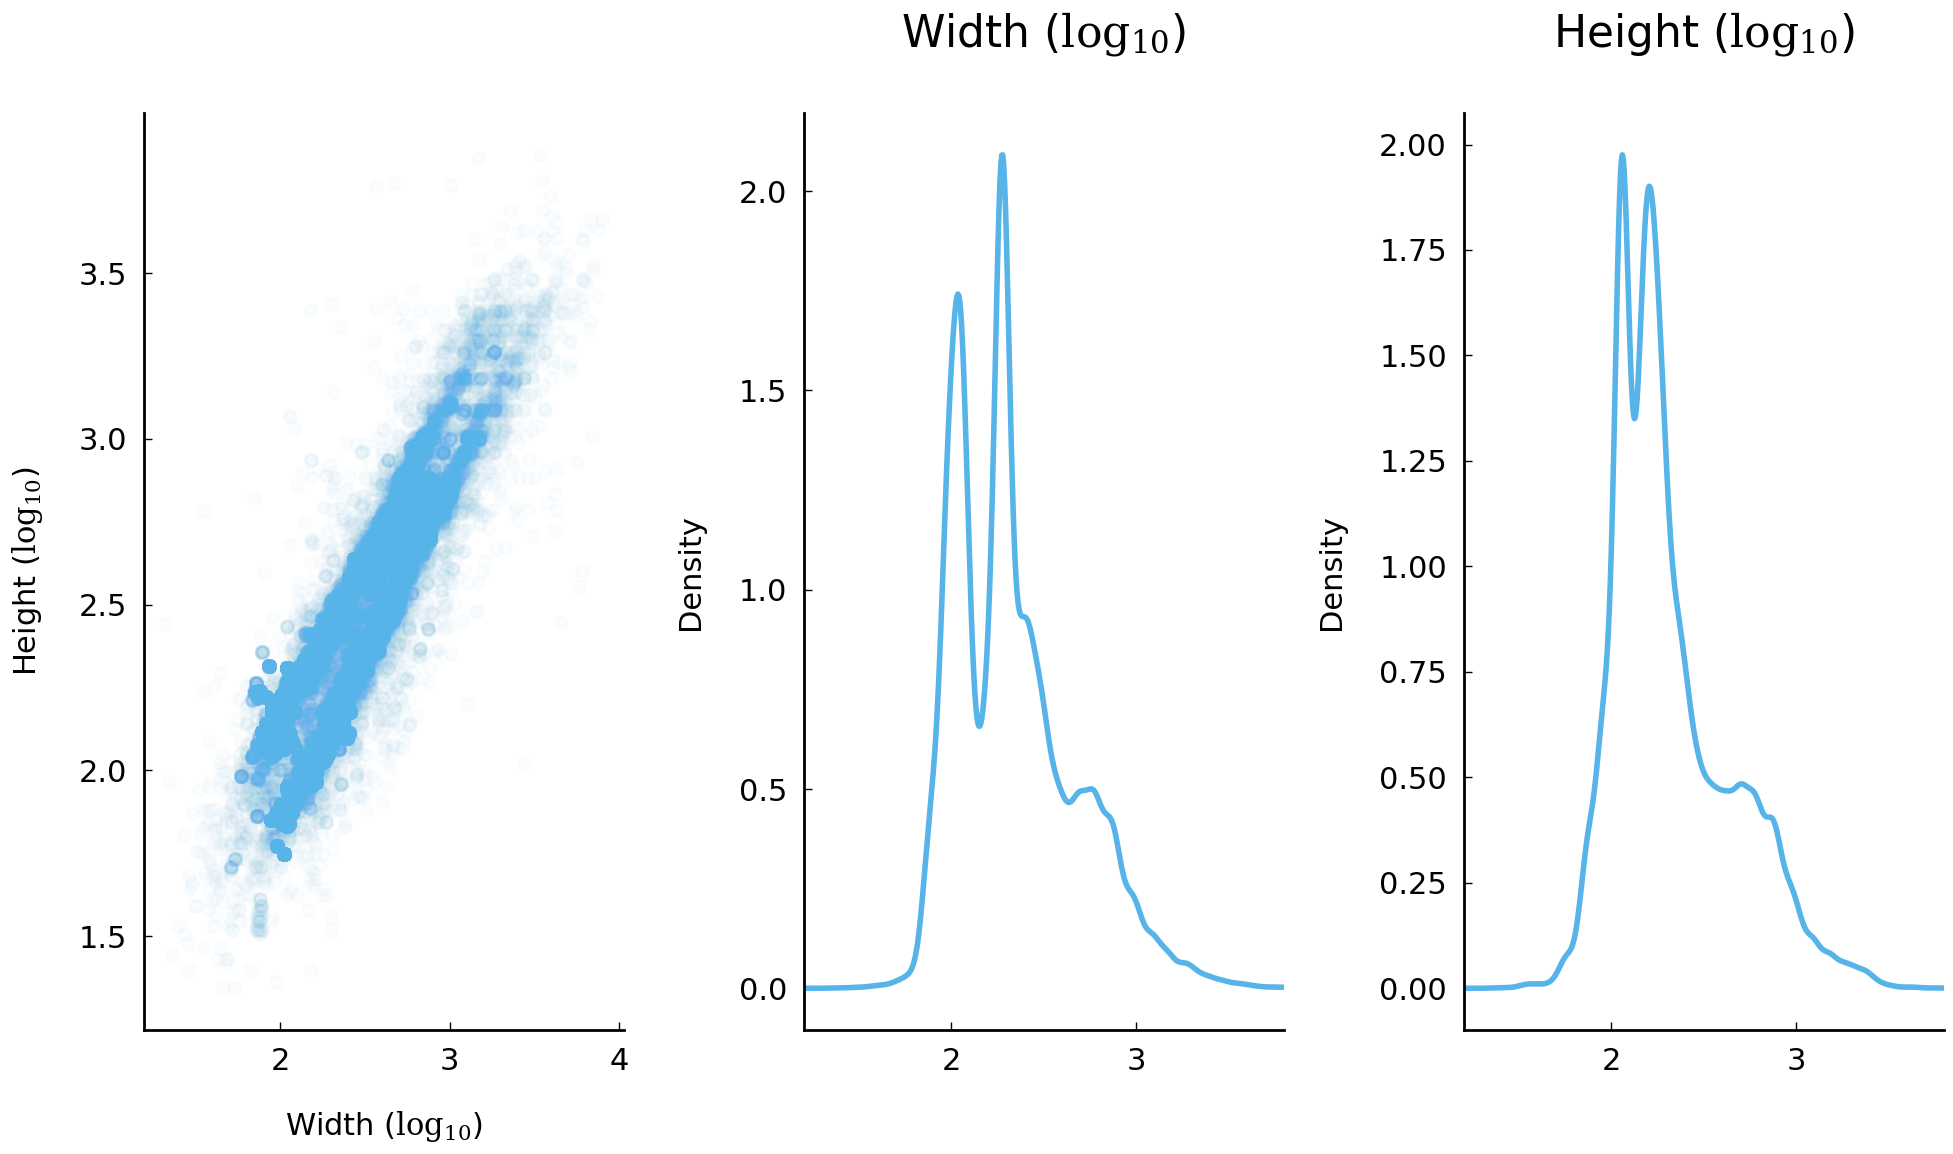

In [8]:
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(1, 3, figsize=(10, 6))
df.plot(x='width_log10', y='height_log10', kind='scatter', alpha=0.02, ax=axes[0])
axes[0].set(xlabel=r'Width ($\log_{10}$)', ylabel=r'Height ($\log_{10}$)')

df['width_log10'].plot(kind='density', title=r'Width ($\log_{10}$)', ax=axes[1])
df['height_log10'].plot(kind='density', title=r'Height ($\log_{10}$)', ax=axes[2])
xlim = (1.2, 3.8); axes[1].set_xlim(*xlim); axes[2].set_xlim(*xlim)
plt.tight_layout();

<!-- Figure: Scatter plot and smoothed histograms ("kernel density estimates") of width and height.\label{fig-topic-models-histograms} -->

Looking closely at the distribution of measurements, we can see more than one distinct mode. The plots above should make us suspicious that we may perhaps be dealing with the superposition of three (or more) distinct unimodal distributions. If we are persuaded that there is, indeed, a superposition of three normal distributions, then the three modes we see would be the modes of the underlying distributions.

Let's proceed with the supposition that there are indeed three latent (or component)
normal distributions here. We can formalize this intuition by assuming that each sample we
observe is drawn from one of the three distributions. This formalization of our
assumptions turns out to be sufficient to specify a specific probability distribution
(also known as a *sampling model*). This model is known as a normal (or Gaussian) mixture
model. (Mixture models can be associated with arbitrary distributions; the normal
distribution is the most frequently used.) A two-dimensional normal mixture model has a
number of parameters which we will estimate. This process is no different in principle
from estimating the parameters of a single normal distribution---by using, say, the sample
mean and sample covariance. (For discussion of parameter estimation, see chapter
{ref}`chp-intro-probability`.) In addition to the mean and covariance of the three latent
normal distributions, we also need to estimate the <span class="index">*mixing
proportions*</span>. (The mixing proportions are sometimes called *mixture weights* or
*component weights* ({cite:t}`bishop2007pattern`, 110--113). The mixing proportions are
also parameters of the model. These parameters have a special interpretation: they may be
interpreted as describing the proportion of samples coming from each of the latent normal
distributions. Because every observation must come from one of the three distributions,
the mixing proportions sum to one.

The probability density of a single observation $x_i$ in this setting is written using symbols as follows:

$$p(\vec x_i) = \theta_1 \text{Normal}(\vec x_i|\vec \mu_1, \Sigma_1) + \theta_2
\text{Normal}(\vec x_i | \vec \mu_2, \Sigma_2) + \theta_3 \text{Normal}(\vec x_i | \vec
\mu_3, \Sigma_3)$$

$$0 \le \theta_i \le 1 \,\text{for}\, i \in \{1, 2, 3\}$$

$$\theta_1 + \theta_2 + \theta_3 = 1$$

```{margin}
That is, $\text{Normal}(x|\mu, \Sigma)$ is shorthand for $p(x|\mu, \Sigma) = \frac{1}{(2\pi)^p}|\Sigma|^{-1/2} \exp{-\frac{1}{2}(x - \mu)^T \Sigma^{-1} (x-\mu)}$ where $x$ and $\mu$ are $p$-dimensional vectors and $\Sigma$ is a $p\times p$ covariance matrix. Here $p$ is 2 as we are modeling observations of width and height.
```
where $\text{Normal}(\vec x|\mu, \Sigma)$ is the <span class="index">probability density function</span> (pdf) of a bivariate normal distribution with mean $\mu$ and covariance $\Sigma$. Probability density functions are the continuous analog of probability mass functions, discussed in chapter {ref}`chp-intro-probability`.

The probability density for all observations is the product of the probability density of individual observations:

```{math}
:label: eq-topic-models-normal-mixture-model

\begin{aligned}
p(\vec x) &= \prod_i^n p(\vec x_i) \\
&= \prod_i^n \theta_1 \text{Normal}(\vec x_i|\vec \mu_1, \vec \Sigma_1) + \theta_2 \text{Normal}(\vec x_i|\vec \mu_2, \vec \Sigma_2) + \theta_3 \text{Normal}(\vec x_i|\vec \mu_3, \vec \Sigma_3) \\
\end{aligned}
```

```{margin}
This is this same '<span
class="index">maximum likelihood</span>' approach that warrants estimating the parameter
$\mu$ for a normal distribution using the sample mean.
```
Estimating the parameters of this model, $\theta_1, \vec \mu_1, \Sigma_1, \theta_2, \vec
\mu_2, \Sigma_2, \theta_3, \vec \mu_3, \Sigma_3$, can be approached in more than one way.
Here we will use the widely used strategy of estimating the parameters by finding values
which maximize the probability of the observed values. Practical strategies for finding
the maximum likelihood estimates for the parameters in normal mixture models are
well-established. "Expectation maximization" is the most common technique. In this
particular setting (i.e., a bivariate normal mixture model with three components), the
choice of strategy will not make much of a difference. As the scikit-learn library
provides a convenient way of estimating the parameters here, we will use that. The
following lines of code suffice to estimate all the parameters of interest:

In [9]:
# HIDE THIS CELL
np.set_printoptions(suppress=True)  # supress scientific notation

In [10]:
import sklearn.mixture as mixture

gmm = mixture.BayesianGaussianMixture(n_components=3, max_iter=200)
gmm.fit(df[['width_log10', 'height_log10']])

# order of components is arbitrary, sort by mixing proportions (decending)
order = np.argsort(gmm.weights_)[::-1]
means, covariances, weights = gmm.means_[order], gmm.covariances_[order], gmm.weights_[order]

# mu_1, mu_2, mu_3 in the equation above
print("μ's =", means.round(2))
# Sigma_1, Sigma_2, Sigma_3 in the equation above
print("Σ's =", covariances.round(4))
# theta_1, theta_2, theta_3 in the equation above
print("θ's =", weights.round(2))

μ's = [[2.45 2.4 ]
 [2.01 2.21]
 [2.27 2.05]]
Σ's = [[[0.1114 0.1072]
  [0.1072 0.1283]]

 [[0.0047 0.0042]
  [0.0042 0.0047]]

 [[0.0001 0.0001]
  [0.0001 0.0001]]]
θ's = [0.68 0.21 0.11]


In [11]:
# HIDE THIS CELL
assert (means[0].round(2) == [2.45, 2.4]).all()

More legibly, the parameter estimates are:

$$\hat \mu_1 = (2.45, 2.4)\;\;\;   \hat \Sigma_1 = \begin{bmatrix}0.11 & 0.11\\ 0.11 &
0.13\end{bmatrix}$$

$$\hat \mu_2 = (2.01, 2.21)\;\;\;   \hat \Sigma_2 = \begin{bmatrix}0.005 & 0.004\\ 0.004 &
0.005\end{bmatrix}$$

$$\hat \mu_3 = (2.27, 2.05)\;\;\;   \hat \Sigma_3 = \begin{bmatrix}0.0001 & 0.0001\\
0.0001 & 0.0001\end{bmatrix}$$

$$\hat \theta = (0.68, 0.21, 0.11)$$

where circumflexes above the parameters indicate that they are estimates of the parameters of the hypothesized latent distributions.

In the code block above we can see that scikit-learn refers to mixing proportions as "weights" and that the observations are divided between the three component distributions. An equivalent way of expressing the normal mixture model specified in equation {eq}`eq-topic-models-normal-mixture-model` makes explicit the association between individual observations and <span class="index">latent distribution</span>s. The reason for dwelling on this example and offering it here will become clear in the next section. Imagine that the width and height measurements of each artwork is drawn from one of three populations. A generative story of how we arrived at the samples we observe would have the following elements:

```{margin}
A common prior distribution in this setting is the Normal-Inverse-Wishart distribution ({cite:t}`hoff2009first`, chp. 7).
```
1. For each latent distribution $k \in \{1, 2, 3\}$, draw mean and covariance parameters, $\mu_k$ and $\Sigma_k$ from a prior distribution.
2. For each artwork $i$
    - sample, with probability $\theta_1$, $\theta_2$, and $\theta_3$, its latent membership, $z_i$, where $z_i \in \{1, 2, 3\}$;
    - sample the width and height for artwork $i$ from the relevant normal distribution, $\text{Normal}(\mu_{z_i}, \Sigma_{z_i})$.

While we have augmented our model with many new variables (the $z_i$'s), it is not difficult to show that, for any collection of observations, the probability assigned by this narrative is the same as the probability assigned by the model described in equation {eq}`eq-topic-models-normal-mixture-model`.

The plot in {numref}`fig-topic-models-unsupervised-tate-artworks-model` makes visible the latent normal distributions which we have just estimated by drawing ellipses that indicate where observations are likely to be found according to each of the latent normal distributions.

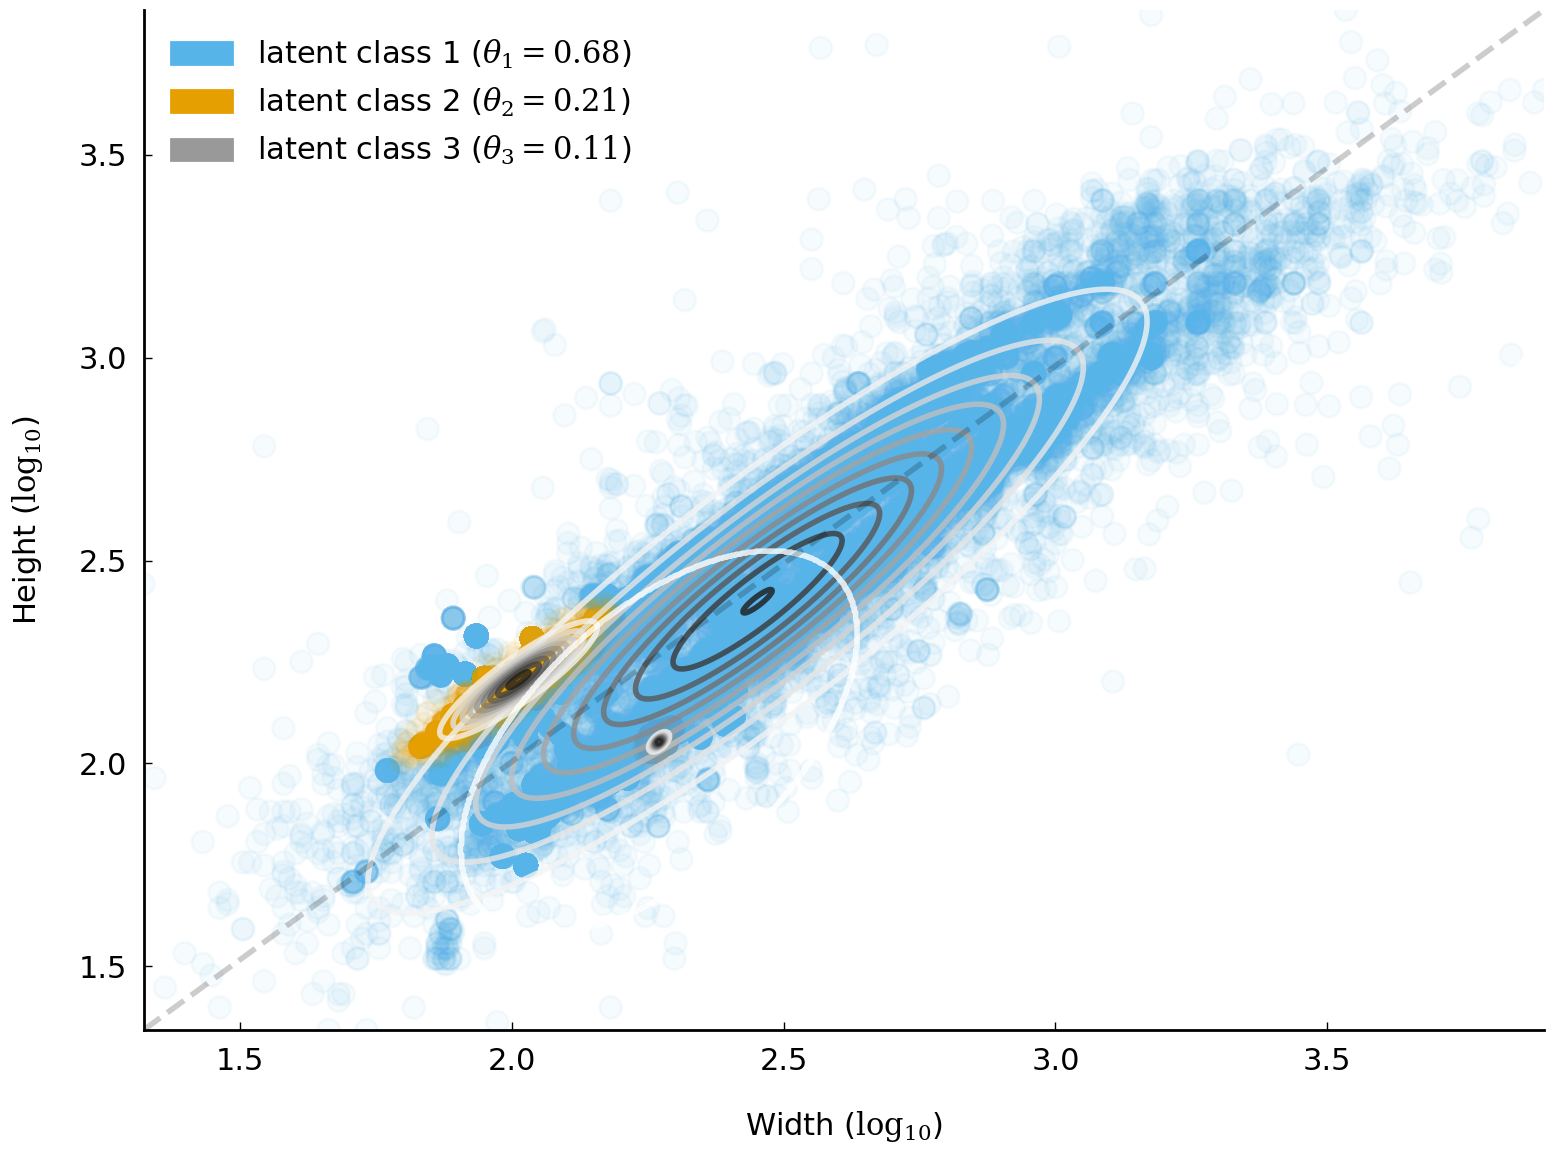

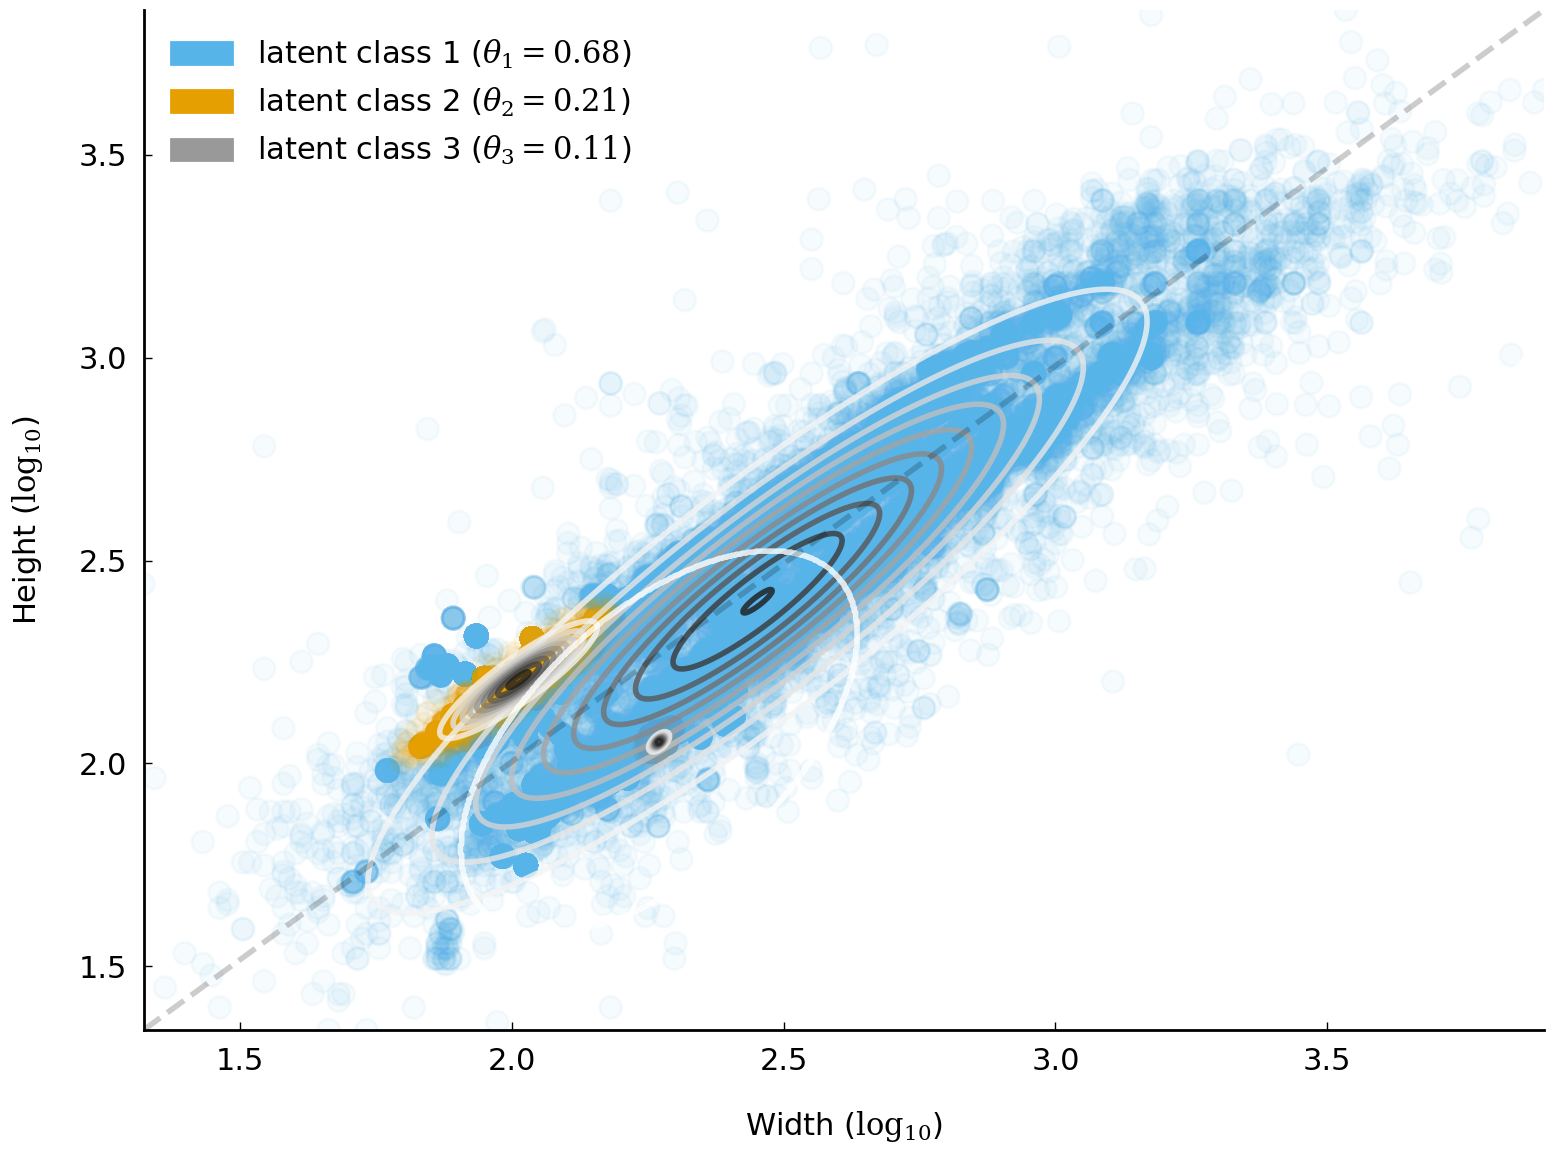

In [12]:
from myst_nb import glue
import scipy.stats
import matplotlib.patches

# reorder responsibilties
responsibilities = gmm.predict_proba(df[['width_log10', 'height_log10']])[:, order]
assert (responsibilities.argmax(axis=1) == 0).mean() > 0.5
color_predicted = [f'C{i}' for i in responsibilities.argmax(axis=1)]
#color_true = [f'C{i}' for i in (df['mf'] == 'F').astype(int)]
x = np.linspace(df['width_log10'].min(), df['width_log10'].max(), 1000)
y = np.linspace(df['height_log10'].min(), df['height_log10'].max(), 1000)
X, Y = np.meshgrid(x, y)
fig, ax = plt.subplots()

for i, (mu, Sigma) in enumerate(zip(means, covariances)):
    pdf = scipy.stats.multivariate_normal(mean=mu, cov=Sigma).pdf
    Z = pdf(np.column_stack([X.ravel(), Y.ravel()])).reshape(X.shape)
    CS = ax.contour(X, Y, Z, 10, alpha=0.8, cmap="Greys")

ax.scatter(df['width_log10'], df['height_log10'],
           color=color_predicted, alpha=0.05)
ax.set(xlabel=r'Width ($\log_{10}$)', ylabel=r'Height ($\log_{10}$)')

patches = [
    matplotlib.patches.Patch(color=f'C{i}', label=rf'latent class {i+1} ($\theta_{i+1} = {theta:.2f}$)')
    for i, theta in enumerate(weights)
]
plt.legend(handles=patches)
plt.plot([0, 1], [0, 1], transform=ax.transAxes, alpha=0.2, linestyle='--', color="black") # diagonal line
plt.tight_layout();

from myst_nb import glue
glue("fig_tate", fig, display=False)

```{glue:figure} fig_tate
---
name: fig-topic-models-unsupervised-tate-artworks-model
---

Unsupervised model of Tate artworks. Scatter plot points are observed width and height pairs. Colors indicate the predicted latent class. Points on the dotted diagonal line are squares, with width equal to height.
```

```{margin}
We leave reproducing these findings as an exercise. Note that more than 60% of the records in our Tate data are associated with J.M.W. Turner (1775-–1851). The Tate has more than 30,000 artworks (oil paintings, watercolors, and sketches) from Turner in its collections.
```
{numref}`fig-topic-models-unsupervised-tate-artworks-model` includes additional information. It also shows, for each observation, which component distribution is most likely responsible for the observation. Remarkably, these latent assignments map reasonably well to three classes of artworks. Virtually all oil-on-canvas paintings are associated with latent class 1, the largest class. Most etchings and engravings are in latent class 2. And more than 95% of artworks in latent class 3 are sketches on paper using ink or graphite.

There are a variety of ways to interpret this result, in which the model "classifies" artworks despite being provided no information about candidate categories or assignments of instances to categories. We do not want, at this point, to offer any particular interpretation other than to offer the model as an example of an unsupervised model. We will, however, caution readers against reifying assignments derived from a mixture model or a mixed-membership model. When dealing with human-produced artifacts such as texts and artworks, mixture models and topic models are appropriately treated as useful tools for <span class="index">exploratory data analysis</span> and nothing more.

Due in no small part to their success at identifying salient patterns with minimal human intervention, mixture models are a workhorse in data analysis. If we can describe a <span class="index">generative process</span>---a narrative whose central characters are probability distributions---which yields the observed samples, we often can model features of interest without relying on labels provided by human experts. In any setting where expert labels are unreliable or expensive or undesirable in principle, this is convenient. Furthermore, in data analysis of historical data we often are confronted with situations where "expert labels" describing latent features of interest are unavailable *in principle* since they could only have been provided by contemporaries (who are no longer around). In such situations, unsupervised models can offer a way forward.

If this particular example---modeling height and width of artworks with normal distributions---seems distant from modeling the morphology of text documents, we assure you that
it is relevant. Although the standard topic model we describe below ("<span class="index">latent Dirichlet allocation</span>")
does not feature a normal mixture model, other topic models do. One which is of
interest to historians is the "<span class="index">dynamic topic model</span>" which uses normal distributions to model word
use in a large document corpus over time {cite:p}`blei2006dynamic,glynn2018bayesian`. Another topic model featuring
normal distributions, the "<span class="index">correlated topic model</span>", has been used to study the history of science {cite:p}`blei2007correlated`. That a model featuring Dirichlet distributions rather than normal distributions is more familiar is due to the
former's mathematical tractability: simplifications can be made when working with the combination
of a Dirichlet and a categorical distribution that cannot be made when working with the combination of a normal distribution and a
categorical distribution. 
```{margin}
Those interested
in comparing the normal distribution (appearing in the form of a logistic normal distribution)
with the Dirichlet distribution in the context of topic models will find a comprehensive review in
chapter 4 of {cite:t}`mimno2012topic`.
```
These mathematical simplifications lower the
computational burden associated with estimating model parameters. If
computational constraints disappear in the future, odds are that topic
models involving (logistic) normal distributions will be used more frequently as they are considerably more
expressive than the Dirichlet distributions featured in the standard topic model.

(sec-topic-models-mixed-membership-models)=
## Mixed-Membership Model of Texts

Mixed-membership models are generalizations of the mixture model we have just encountered. When applied to text data, <span class="index">mixed-membership model</span>s are often referred to as "topic models". The moniker "<span class="index">topic model</span>" is not particularly informative. (It's as (un)helpful as calling our model of artworks a "morphology model".) Mixed-membership models allow us to automatically distinguish different groups of observations in our data, where each group gets its own, particular, mixture model. In the case of our artworks model, for example, each group might be a different museum collection, or, when our observations are individual works in a large corpus, each "group" of observations is a document.

In this chapter we are interested in exploring the history of the US Supreme Court through its published opinions. To model the documents using the mixed-membership model, we need to make two alterations to our existing mixture model. First, we need to replace the normal distribution with a distribution better suited to modeling non-negative counts such as word frequencies. In this case we will use the <span class="index">categorical distribution</span>, which is among the simplest models of discrete data available. The categorical distribution is a multivariate version of the Bernoulli distribution. (Discrete probability distributions are discussed in chapter {ref}`chp-intro-probability`). Second, we need to allow each observation (document) to be associated with its own particular set of mixing proportions. If we wanted to continue the analogy with the model of artworks, we would need to adjust the story slightly. If we had multiple distinct collections of artworks from different museums, a mixed-membership model would have inferred mixing proportions for each museum separately. If we had done this---and fit a mixed-membership model of the artworks---a collection of artworks would play the same role as a single document in the corpus.

What we observe in the case of the Supreme Court corpus are words, grouped into documents. Our documents will be *opinions* issued by individual judges.  While many published Supreme Court decisions have a single author who writes on behalf of the majority, many decisions contain distinct documents, opinions, by different authors. A judge who strongly disagrees with the majority opinion may contribute a "dissent". A judge who agrees with the majority decision but wishes to offer an additional or an alternative rationale will "concur" and contribute his or her own opinion. Each of these texts counts as a "document".
```{note}
There are also *per curiam* opinions which are not associated with a specific judge. These unsigned opinions are not included in the dataset.
```


```{margin}
In 2015 the then candidate Donald Trump cited the policies of Franklin D. Roosevelt, whose detention of Japanese citizens *Korematsu* ruled legal, in support of plans, posted on the then candidate's website, to ban Muslims from entering the United States. Trump's supporters cited *Korematsu* explicitly. The 1944 decision lives on both in a legal sense---it was never explicitly overturned---and in the sense that American politicians draw on reasoning contained within the decision to support their policies today.
```
Each text, along with associated metadata such as the citation and year of publication, is stored using line-delimited JSON in the compressed file ``data/supreme-court-opinions.jsonl.gz``. The Pandas library knows how to read this kind of data, provided it is uncompressed first. The following block of code loads the corpus into a ``DataFrame`` and displays records associated with the 1944 decision [*Korematsu v. United States*](https://en.wikipedia.org/wiki/Korematsu_v._United_States), which ordered Japanese Americans, including those who were United States citizens, into internment camps.

In [13]:
import os
import gzip
import pandas as pd

with gzip.open('data/supreme-court-opinions-by-author.jsonl.gz', 'rt') as fh:
    df = pd.read_json(fh, lines=True).set_index(['us_reports_citation', 'authors'])

In [14]:
df.loc['323 US 214']

case_id                                               text  \
authors                                                                    
black        1944-018  \nOPINION BY: BLACK\nOPINION\nMR. JUSTICE BLAC...   
frankfurter  1944-018  \nCONCUR BY: FRANKFURTER\nMR. JUSTICE FRANKFUR...   
roberts_o    1944-018  \nDISSENT BY: ROBERTS; MURPHY; JACKSON\nMR. JU...   
murphy       1944-018  \nMR. JUSTICE MURPHY, dissenting.\nThis exclus...   
jackson_r    1944-018  \nMR. JUSTICE JACKSON, dissenting.\nKorematsu ...   

                type  year  
authors                     
black        opinion  1944  
frankfurter   concur  1944  
roberts_o    dissent  1944  
murphy       dissent  1944  
jackson_r    dissent  1944

The records above show that Justice Hugo Black authored the opinion for the Court. (Judges on the Supreme Court are given the title "Justice" and often referred to as "justices".) Justice Frankfurt authored a concurring opinion and Justices Owen Roberts, Frank Murphy, and Robert Jackson authored dissenting opinions. The ``text`` variable stores the relevant texts. The following block of code displays the first lines of Justice Murphy's dissent.

In [15]:
print(df.loc['323 US 214'].loc['murphy', 'text'][:500])


MR. JUSTICE MURPHY, dissenting.
This exclusion of "all persons of Japanese ancestry, both alien and non-alien," from the Pacific Coast area on a plea of military necessity in the absence of martial law ought not to be approved.  Such exclusion goes over "the very brink of constitutional power" and falls into the ugly abyss of racism.
In dealing with matters relating to the prosecution and progress of a war, we must accord great respect and consideration to the judgments of the military authorit


We can appreciate the span of time covered by this corpus by making a histogram of the
years. The figure below shows that the corpus includes 34,677 texts published between 1794 and 2008.

In [16]:
# HIDE THIS CELL, reality check
assert len(df) == 34_677

<AxesSubplot:>

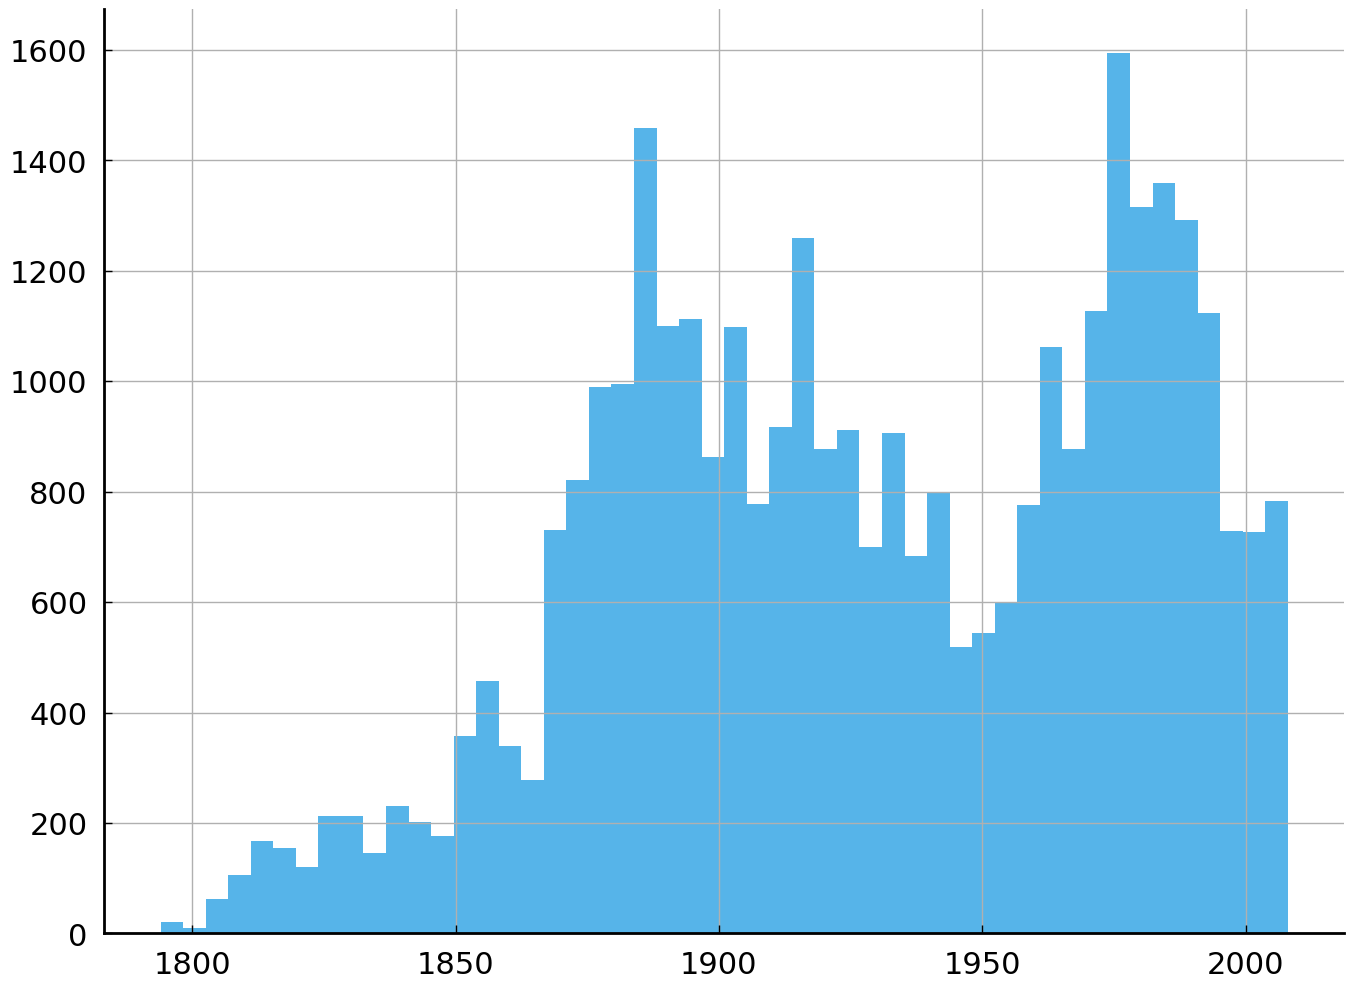

In [17]:
df['year'].hist(bins=50)

<!-- Figure: Histogram of the corpus, which includes 34,677 texts published between 1794 and 2008.\label{fig-topic-models-corpus-histogram} -->

In [18]:
df['year'].describe()

count    34677.000000
mean      1928.824552
std         48.821262
min       1794.000000
25%       1890.000000
50%       1927.000000
75%       1974.000000
max       2008.000000
Name: year, dtype: float64

Having a rough sense of what the corpus contains and what counts as a document, we need to take one additional step to get to our observables, the individual words. Building a vocabulary and tokenizing texts stored as strings should be a familiar task at this point (cf. chapter {ref}`chp-vector-space-model`). Whereas we carefully constructed a <span class="index">document-term matrix</span> in chapter {ref}`chp-vector-space-model`, here we allow the software package scikit-learn to perform many of the steps for us. The following block of code employs scikit-learn's <span class="index">``CountVectorizer``</span> to construct a document-term matrix for the 34,677 opinions in the corpus. To make the computation process and the subsequent analysis of the fitted model easier, we will ignore case by lowercasing all words and exclude from our vocabulary (rare) words occurring in fewer than 100 texts (about 0.3% of documents). We will also exclude very common words (i.e., "stop words") using an English stop words list packaged with scikit-learn. Although removing low-frequency words and stop words is neither necessary nor recommended {cite:p}`schofield2017pulling`, we remove the words, in this pedagogical setting, to reduce the considerable time required to fit the topic model.

In [19]:
import sklearn.feature_extraction.text as text

# min_df: ignore words occurring in fewer than `n` documents
# stop_words: ignore very common words ("the", "and", "or", "to", ...)
vec = text.CountVectorizer(lowercase=True, min_df=100, stop_words='english')
dtm = vec.fit_transform(df['text'])

In [20]:
print(f'Shape of document-term matrix: {dtm.shape}. '
      f'Number of tokens {dtm.sum()}')

Shape of document-term matrix: (34677, 13231). Number of tokens 36139890


At this point we have a compact representation of our observations, the words in the corpus, grouped by document. This happens to be the familiar document-term matrix, introduced in chapter {ref}`chp-vector-space-model`. For our present purposes, we can stick to the efficient, sparse matrix that is returned by the vectorizer. The document-term matrix does not figure in the mixed-membership model as such. We use it here because it is a convenient and efficient data structure for storing word frequencies.

In the <span class="index">mixed-membership model</span>, the words, $w_{d, 1}, w_{d, 2}, \ldots, w_{d,n_d}$, of each Supreme Court document $d$ will be associated with a mixture of $K$ <span class="index">categorical distribution</span>s. While three <span class="index">latent distribution</span>s captured the heterogeneity in artwork morphology in the previous section, useful models of texts written by humans will typically require more latent distributions. A typical number of latent distributions is 100, 200, or 500. In the context of topic modeling, this number is often referred to as the number of "<span class="index">topics</span>" or semantic domains which we believe our model should take into account. $K$ is a parameter of the model but one which we fix in advance. (There are mixed-membership models of text which infer $K$ from data {cite:p}`buntine2014experiments`.) In the context of an exploratory data analysis with a large corpus such as this one, most values of $K$ higher than 50 will produce useful results. In practice, time and computational budgets often require choosing a $K$ less than 500.

```{tip}
Those concerned about picking a particular $K$ should consider calculating the held-out likelihood of a small portion of their corpus given different settings for $K$. Stop increasing $K$ when increasing the number starts to provide diminishing returns. In an exploratory data analysis, picking a "correct" value of $K$ should not be a concern.
```

Once we have a fixed value of $K$, however, the form of the mixture model for a single document $d$, viewed as a sequence of words $w_{d, 1}, w_{d, 2}, \ldots, w_{d,n_d}$, resembles the form encountered in equation {eq}`eq-topic-models-normal-mixture-model`. The major differences are the number of component distributions ($K$ instead of two) and the type of distribution used (categorical instead of normal). The probability of an individual word is the sum over all topics of the word's probability in a topic times the probability of a topic in the current document. In symbols, the probability of a document is written as follows:

```{math}
:label: eq-topic-models-document-mixture-model
p(\vec w_d) = \prod_i^{n_d} p(w_{d,i}) = \prod_i^{n_d} \sum_k^K \theta_{d,k} \text{Categorical}(w_{d,i}|\vec\phi_k)
```
where $\text{Categorical}(x|\vec\phi_k) = \prod_v^V \phi_{k, v}^{x^{(v)}}$ and we have encoded the word $x$ as a "one-hot" vector of length $V$ and $x^{(v)}$ is the $v$th component of $x$. As this model ignores word order, we are free to use the counts from our document-term matrix directly, picking $w_{d, 1}$ to be the first word in our document-term matrix associated with document $d$ and continuing through $w_{d, n_d}$, the last word in the document-term matrix associated with the document.

In the equation above, $\theta_{d,1}, \ldots, \theta_{d,1}$ play the same role as the component weights in the earlier normal mixture model (Equation {eq}`eq-topic-models-normal-mixture-model`). The component-specific parameters $\vec\phi_1, \ldots, \vec\phi_K$ here play the same role as the component-specific parameters $(\vec \mu_1, \Sigma_1)$ and $(\vec \mu_2, \Sigma_2)$ in the earlier model.

Before going further, let us pause for a moment and imagine what the parameters $\vec\phi_k$ and $\vec\theta_d$ might plausibly look like in the case of a handful of a Supreme Court documents modeled with only two <span class="index">latent distribution</span>s or "topics". Suppose that, in this document, the writer deliberates about whether or not a city should restrict individuals and organizations from protesting on public streets on public safety grounds---protesters and counter-protesters might use physical violence against their opponents or the public. We would imagine that those wishing to assemble would appeal to their right of freedom of speech, arguing that free speech is of limited value without public spaces in which to exercise it. In a document summarizing these opposing points of view, we might imagine two very different topic distributions, each a probability distribution over the vocabulary: the first distribution would assign high probability to words such as *safety*, *injury*, *liability*, and *damages*, whereas the second distribution would assign high probability to words such as *speech*, *assembly*, *rights*, and *constitution*. The mixing weights in this document might be roughly equal. Elsewhere, in opinions exclusively focused on free speech, the weight assigned to the second topic might dominate.

Equation {eq}`eq-topic-models-document-mixture-model` is a model of the words associated with a
single document. However, we need to model all words in the $D$ documents in our corpus. Shared
latent distributions across all documents will allow us to model the <span class="index">semantic homogeneity</span> which
exists across documents. Allowing each document to have a separate set of <span class="index">mixing weight</span>s will
let us to respect the heterogeneity of the corpus. Some documents will, for example, feature
certain latent distributions more prominently than others.

```{note}
It is possible to model all words
from all documents as being drawn from a single mixture distribution. Such a model would be a
perfectly valid mixture model but would fail to model the heterogeneity we know is present in the
corpus.
```

Allowing each document to have distinct
mixing weights is the second change we need to make in order to arrive at our mixed-membership model. This particular mixed-membership model is commonly known as <span class="index">latent Dirichlet allocation</span> (<span class="index">LDA</span>) {cite:p}`blei2003latent`. (The same model had been used earlier to analyze the genetic characteristics of birds {cite:p}`pritchard2000inference`.) The
name "latent Dirichlet allocation" will appear daunting at first sight, but in fact, it should not be the source of any mystery. "Latent" refers to the concept of <span class="index">latent
distribution</span>s in the model, and "<span class="index">Dirichlet</span>" names the most commonly used prior distributions on the component
distribution parameters $\phi_{1:K}$ and on the mixing weights, $\theta_{1:D}$.

Similar to our description of a probability model in section
{ref}`sec-topic-models-mixture-models`, we will describe this mixed-membership model, LDA,
with its generative narrative. The following describes how we arrive at a given
observation (an individual word). Begin by sampling parameters for the mixture components
("topics"), $\phi_{1:K}$:

1. For each component $k$, sample a probability distribution $\phi_k$ from $\text{Dirichlet}(\eta)$.
2. For each document $d$,
   - sample a document-specific set of mixing weights, $\theta_d$, from a Dirichlet distribution with parameter $\alpha$;
   - for each word $w_{d, i}$ in document $d$,
       * sample a word-specific latent mixture component, $z_{d, i}$, from the document-specific mixing weights $\theta_d$;
       * sample a word from the latent distribution, $w_{d, i} \sim \text{Categorical}(\phi_{z_{d,i}})$;

We can write down the sampling distribution associated with this generative narrative. In fact,
we already wrote down the important part of the model a moment ago: the probability of words in a document,
$p(w_d)$. Expressing the probability of the entire corpus requires accounting for the
document-specific mixing weights. In symbols the model reads:

\begin{align*}
p(w_{1:D}|\theta_{1:D},\phi_{1:K}) = \prod_{d=1}^D p(w_d) &= \prod_{d=1}^D \prod_i^{n_d} p(w_{d,i}|\theta_d,\phi_{1:k}) \\
                                                          &= \prod_i^{n_d} \sum_k^K \theta_{d,k} \text{Categorical}(w_d|\phi_k)\\
\end{align*}

Inferring the parameters $\theta_{1:D}$ and $\phi_{1:K}$ is challenging for many of the same reasons
that estimating the parameters of a simple mixture model is challenging.

```{note}
The problem of "label switching" is perhaps the most familiar challenge
    here {cite:p}`stephens2000dealing`. Given the corpus, the model gives the same probability with parameters $\theta_{1:D}$ and
    $\phi_{1:K}$ as with parameters $\theta_{1:D}^\prime$ and $\phi_{1:K}^\prime$, where the latter are
    identical except the components and mixing weights have been shuffled. For example, the parameters of the second
    latent distribution $\phi_2$ might be swapped with the first $\phi_1$ and the values of each
    $\theta_d$ updated accordingly (swapping $\theta_{d, 1}$ with $\theta_{d, 2}$). Such a situation naturally foils any effort to estimate parameters
    by maximizing distribution since there are $K!$ permutations of the parameters among which the model does not distinguish.
    The model is not "identified", to use the technical term. {cite:t}`bishop2007pattern`
    (section 9.2) discusses this problem in the context of mixture models. 
<!-- NOTE: Bishop only talks about it very briefly. A better citation would be helpful. -->
```

(sec-topic-models-parameter-estimation)=
### Parameter estimation

```{margin}
<span class="index">Gibbs sampling</span> is the other approach commonly used in this setting. The different approaches can produce very different results {cite:p}`buntine2014experiments`. For example, variational inference tends to underestimate the support of the posterior distribution ({cite:t}`murphy2012machine`, section 21.2.2). <!-- @murphy2012machine p. 735 --> Software for topic modeling which does not use variational inference and, moreover, incorporates important theoretical improvements on the original topic model exists. Two important non-Python implementations are {cite:t}`mccallum2002mallet` and {cite:t}`buntine2016hca`.
```
As with the mixture model, there are several strategies for estimating the parameters of a mixed-membership model. Here, we will use the implementation packaged by scikit-learn which is available in the class, <span class="index">``LatentDirichletAllocation``</span>. This implementation uses an approximation strategy known as <span class="index">variational inference</span> to estimate the model's parameters. As was the case with the mixture model, the parameters which are estimated are those associated with the latent distributions, $\phi_{1:K}$, which we will refer to as the "<span class="index">topic-word distributions</span>" and the mixing weights for each document, $\theta_{1:D}$, which we will refer to as the "<span class="index">document-topic distributions</span>."

In [21]:
import sklearn.decomposition as decomposition
model = decomposition.LatentDirichletAllocation(
    n_components=100, learning_method='online', random_state=1)

In [22]:
document_topic_distributions = model.fit_transform(dtm)

We can verify that the parameters which have been estimated are those we are expecting. Following its own naming convention, which we encountered in our model of artworks, scikit-learn puts the parameters of the latent distributions in the attribute ``components_``. Since we have 100 topics, we anticipate that there will be 100 sets of latent parameters. The document-topic distributions, one for each document in our corpus, are returned by the call to the method of ``LatentDirichletAllocation``, ``fit_transform()``. Each document-topic distribution is a distribution over the topics. Inspecting the shapes of these parameters, we can verify that things are working correctly.

In [23]:
vocabulary = vec.get_feature_names()
# (# topics, # vocabulary)
assert model.components_.shape == (100, len(vocabulary))
# (# documents, # topics)
assert document_topic_distributions.shape == (dtm.shape[0], 100)

/usr/local/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Since every parameter is associated with a topic and either a vocabulary element or a document, it will be convenient to make this association explicit by converting the arrays which hold the parameter estimates into ``DataFrame``s with named rows and columns.

In [24]:
topic_names = [f'Topic {k}' for k in range(100)]
topic_word_distributions = pd.DataFrame(
    model.components_, columns=vocabulary, index=topic_names)
document_topic_distributions = pd.DataFrame(
    document_topic_distributions, columns=topic_names, index=df.index)

At this point, we can refer to the document-specific set of $K$ mixing weights using the same index we used to examine the text of the opinions. In a related fashion, we can refer to the parameters of the latent probability distributions over the vocabulary by the topic name. The following block shows how we can extract the mixing weights associated with Justice Murphy's dissent. For the sake of brevity, we will extract the first ten weights.

In [25]:
document_topic_distributions.loc['323 US 214'].loc['murphy'].head(10)

Topic 0    0.000012
Topic 1    0.000012
Topic 2    0.000012
Topic 3    0.000012
Topic 4    0.002581
Topic 5    0.000012
Topic 6    0.000012
Topic 7    0.000012
Topic 8    0.111934
Topic 9    0.004283
Name: murphy, dtype: float64

As can be observed from the resulting table, only a few of the mixing weights are large. Most are very small, reflecting the fact that the component distribution does not feature prominently in the associated latent (topic-word) distribution. This is typical in topic models. We will explore why that might be expected in a moment. To focus on the latent distributions which do feature prominently in the model, we can sort the mixing weights in descending order. The following block shows the top ten weights for Murphy's dissent:

In [26]:
murphy_dissent = document_topic_distributions.loc['323 US 214'].loc['murphy']
murphy_dissent.sort_values(ascending=False).head(10)

Topic 8     0.111934
Topic 49    0.105802
Topic 17    0.090878
Topic 44    0.088893
Topic 93    0.071995
Topic 12    0.068529
Topic 35    0.061863
Topic 22    0.060224
Topic 52    0.053225
Topic 23    0.046771
Name: murphy, dtype: float64

Let us inspect the parameters of the most prominent latent distribution, "Topic 8". We will perform the same trick of sorting the parameters of the latent distribution in descending order to focus our attention on the most probable words under the distribution. The following block lists the most probable words associated with Topic 8. Note that scikit-learn's implementation of LDA stores topic-word distributions as unnormalized counts instead of probabilities.

<!-- NOTE: in cell block below we really do have to list up to 18 items to get to "minority" -->

In [27]:
topic_word_distributions.loc['Topic 8'].sort_values(ascending=False).head(18)

state             7423.743632
political         5763.436445
equal             5357.940314
voting            5218.087219
vote              4967.097213
district          4892.887730
race              4834.578115
court             4516.218149
districts         4058.671278
citizens          3721.802863
discrimination    3474.157221
protection        3307.064849
white             3260.580086
voters            3164.272633
elections         3067.852361
population        2830.923584
minority          2682.576553
black             2637.436064
Name: Topic 8, dtype: float64

In [28]:
# HIDE THIS CELL, reality check
assert topic_word_distributions.loc['Topic 8'].shape == (13_231,)

It seems reasonable to say that this topic features words associated with discrimination based on physical traits and ancestry. The distribution assigns relatively high probability to words such as *race*, *discrimination*, and *minority*. Words associated with this topic account for approximately 11% of the words in Justice Murphy's opinion. This too makes sense as Justice Murphy is addressing a challenge to the detention of a Japanese American, Fred Korematsu, based on Korematsu's ancestry.

The topic features other words as well, including words associated with voting (e.g., *voting*, *vote*, *voters*). There are many ways to summarize this distribution, in addition to the best "summary": the distribution itself (i.e., the vector of 13,231 values). One common way to summarize a distribution over words is to list words assigned significant probability. Often this list is short. There are, for example, only 93 words given a probability greater than 1 in 500 by this topic-word distribution. (In a bag-of-words language model, a word occuring at least once every few paragraphs would get a probability of 1 in 500 or higher.) If space available to summarize the distribution is limited, a shorter list of words can be displayed. Above we show the top 18 words. In the figures in this chapter we show as many words as space permits. We do not perform any additional filtering of the words.

```{note}
It is telling that there are two distinct topics, Topic 8 and Topic 15, which both feature prominently words related to discrimination against minorities. Topic 8 appears to relate to the voting rights (or lack thereof) of non-whites. The other topic, Topic 15, is more strongly associated with the legality of segregation based on ancestry or physical appearance. That the topic model distinguishes words and documents associated with these topics is due to the existence of a range of words which do not co-occur (e.g., "voting" would rarely occur in a document which has the word "schooling").
```

Looking at the parameter estimates associated with Murphy's dissent in *Korematsu* and with the latent distribution labeled Topic 8, we have superficial evidence that the topic model is able to find a plausible "semantic decomposition" of the corpus, one which can capture underlying trends in the prevalence of certain subject matter in the opinions. The latent topic distributions are still probability distributions over the vocabulary but at this point we might be willing to entertain domesticating them with the moniker "topics".

One informal way to verify that the representation provided by the model is useful
involves looking at the ordered mixing weights for each document. Doing so will allow us
to compare our intuitions about how documents might be said to be constructed from
semantically coherent "components" with the model's representations of the documents. For
example, we should be comfortable with the intuition that most individual Supreme Court
opinions only deal with a tiny subset of the range of recurrent legal issues appearing in
the corpus. A given judicial opinion is likely to limit itself to talking about a few
areas of law; it is very unlikely to talk about, say, twenty or more distinct areas of
law. To describe this intuition in terms aligned with the current model we would say the
following: we do not anticipate the document-specific mixing weights to be anywhere near
uniform. A simple way to check this prediction is to plot the document-specific mixing
weights for a random sample of documents, ordering the weights in descending order:

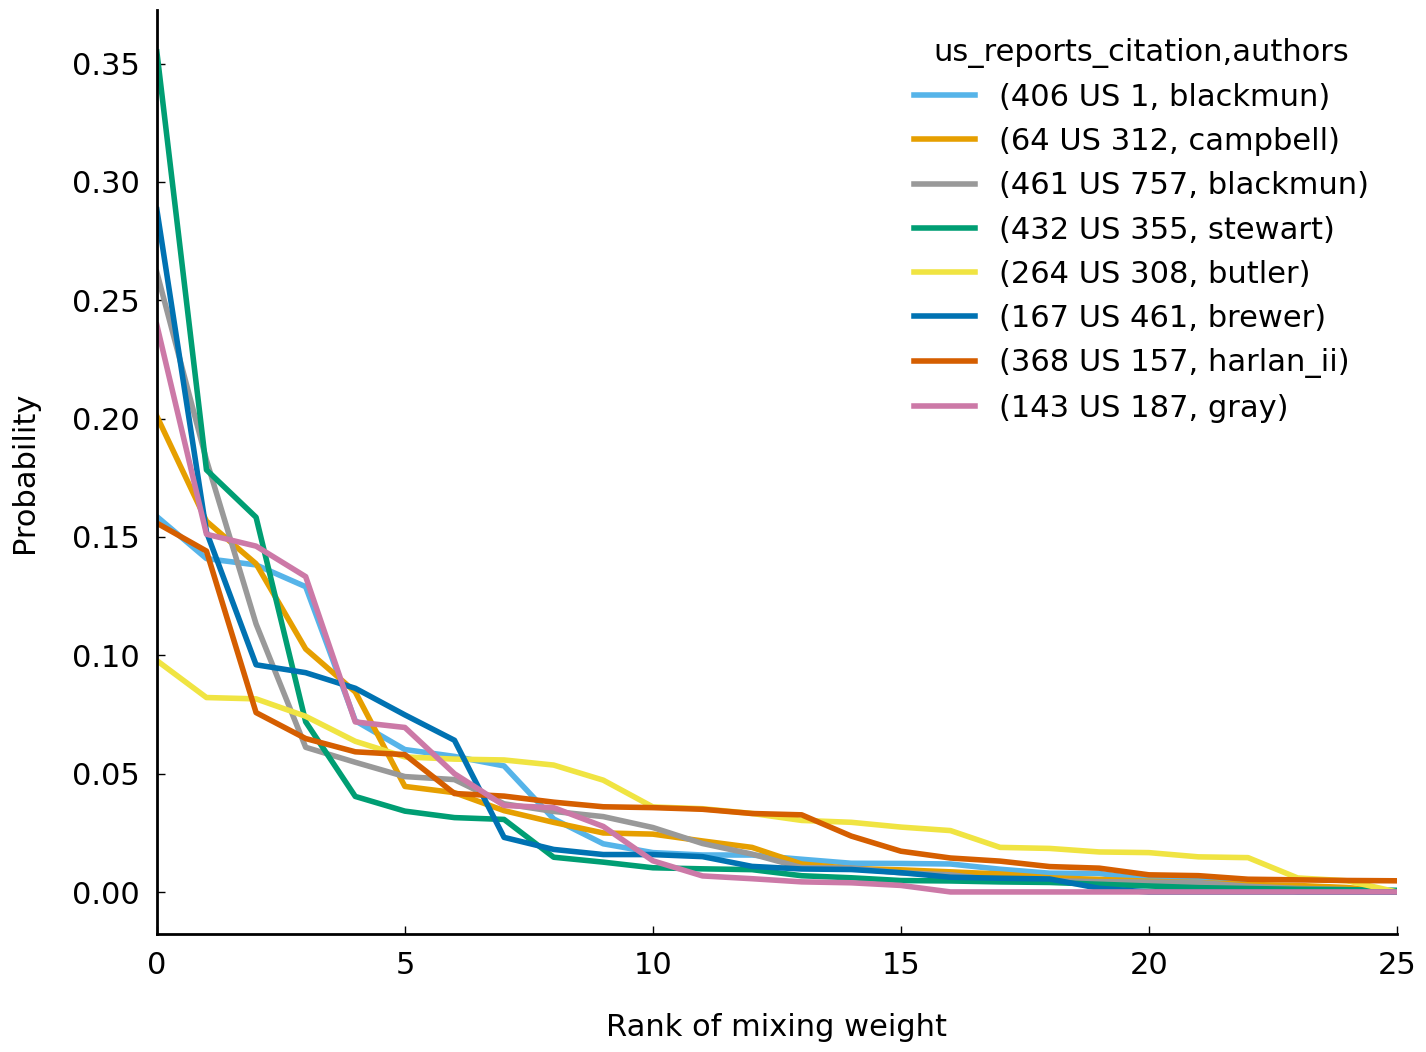

In [29]:
weights_sample = document_topic_distributions.sample(8)
weights_ordered = weights_sample.apply(
    lambda row: row.sort_values(ascending=False).reset_index(drop=True), axis=1)
# transpose DataFrame so pandas plots weights on correct axis
ax = weights_ordered.T.plot()
ax.set(xlabel='Rank of mixing weight', ylabel='Probability', xlim=(0, 25));

<!-- Figure: Document-specific mixing weights for a random sample of documents.\label{fig-topic-models-mixing-weights} -->

```{margin}
The term "rank abundance" is borrowed from ecology. This sort of plot resembles a rank abundance curve which is used by ecologists to show the relative abundance of species in a given area.
```
This "<span class="index">rank abundance</span>" curve for the latent topic distributions
shows what we anticipate: most opinions are associated with a handful of distinct latent
distributions, typically fewer than twenty. There is, however, considerable heterogeneity
in "topic abundance" among the top twenty weights: some opinion mixing weights are more
evenly distributed than others. Having subjected the mixed-membership model to some
preliminary tests, we should be curious to see what else it can reveal about the ~35,000
opinions in the corpus. Before we explore trends in the corpus, however, we will subject
our model to some additional scrutiny. Although we have shown it through a spot check of
Topic 8 and an individual opinion, we need to make some effort to verify that the model is
identifying constellations of semantically related words across the entire corpus. 

### Checking an unsupervised model
(sec-topic-models-checking-unsupervised-models)=

There is no widely accepted way to "check" the suitability of a <span class="index">mixed-membership model</span> of a text corpus. One reason for the lack of agreement has to do with what is being modeled. A topic model is a model of word frequencies---and not, say, of sentences. When one is modeling something such as a bag of words that does not align with any human reader's experience of a text, it is hard to use out-of-sample prediction to evaluate the model because what is being predicted is something no human reads or produces. Indeed, even when those doing the evaluation do agree on a measure of "performance", it can be prohibitively taxing to actually do the evaluation {cite:p}`buntine2009estimating`. Nobody actually composes texts in anything remotely like the manner described by the generative narrative. Since opportunities for direct validation of the adequacy of the model are in short supply, we end up having to use indirect validations.

In the case of the model of Supreme Court opinions, we are looking for a validation which will give us some additional confidence that the parameters estimated by the model are capturing salient semantic details of all documents in the corpus. We will settle for an indirect validation provided it has a better claim to be systematic than the adhoc and selective evaluations of the previous section.

```{margin}
In settings when we don't have access to third-party labels we can often commission labels for a small sample. First, take a random sample of, say, 100 documents and ask two people familiar with the subject to independently label the documents using a fixed set of labels. After verifying that the labellers tend to agree---commonly assessed by calculating inter-rater reliability---then the validation described here can be carried out using the small sample of 100 labeled documents.
```
Fortunately, we have a promising validation strategy available: we can verify that the topics associated with decisions are roughly aligned with a set of expert labels that are available for a large subset of the decisions. Although this sort of validation still counts as adhoc and indirect, it is markedly more attractive as a validation technique than inspecting the topics and declaring them "appropriate" or "good enough".  Whereas the latter depends entirely on our own judgment, the former involves third-party expert labels which we have no control over.

Every Supreme Court decision issued after 1945 is assigned to one (and only one) of fourteen "issue areas" in the widely-used Supreme Court Database ([SCDB](http://scdb.wustl.edu/)). These issue areas include "Criminal Procedure", "Civil Rights", "First Amendment" (decisions concerning the freedom of speech), and "Due Process". These issue areas are also frequently called "Spaeth labels" after Harold Spaeth, the contributor of the labels. (We use "Spaeth labels" and "issue area" interchangably.) These issue area classifications are neither particularly precise nor easily reproducible. (The SCDB itself provides the following caution: "The contents of these issue areas are both over- and under-specified; especially those of largest size: criminal procedure, civil rights, and economic activity" ([SCDB Online Code Book: Issue Area](https://web.archive.org/web/20170207172822/http://scdb.wustl.edu/documentation.php?var=issueArea)).) Despite their inadequate or excessive precision, the issue areas provide useful information about the kinds of words likely to appear in a decision. A decision classified under the issue area of "First Amendment" will tend to feature different words than a decision classified under the issue area "Interstate Relations". Because the issue area captures some information about a decision, we can informally validate our topic model's "descriptions" of documents by comparing them with the "descriptions" provided by the Spaeth labels.

This kind of indirect validation strategy has a long history. {cite:t}`blei2003latent`, the paper which popularized the topic model, makes use of this technique with a corpus of manually classified news articles known as "Reuters-21578". And the specific validation strategy we use here---comparing document-topic distributions with the Spaeth labels---appeared earlier in {cite:t}`lauderdale2014scaling`. {cite:t}`lauderdale2014scaling` produce a visualization of the alignment between their topic model of Supreme Court decisions and the Spaeth labels that strongly suggests that their topic model is indeed picking up on meaningful semantic differences ({cite:t}`lauderdale2014scaling`, 762). Although we produce a visualization intended to be directly compared to the visualization of Lauderdale and Clark, there are important differences between the topic models. In comparison to the model used by Lauderdale and Clark (2014), our model is simpler, uses more topics, and makes use of online variational inference.

In order to follow the Lauderdale and Clark validation as closely as possible, we will
focus on the subset of our 100 topics that most closely match the 24 topics used by
Lauderdale and Clark. We match the topics by manually inspecting the top words associated
with each topic. If more than one of our topics match we pick the topic associated with
the greater number of words. {ref}`sec-topic-models-appendix` shows the mapping
and compares our topics' most probable words to the most probable words Lauderdale and
Clark report in their figure. Although we use our topic numbers in our validation, we use
the top topic words from Lauderdale and Clark in order to make comparison of the two
figures easier. Because both figures are produced using topic models of the same corpus,
they should produce broadly similar results.

In [30]:
# HIDE THIS CELL
# lauderdale_clark_label, our_topic_number, our_topic_words
lauderdale_clark_figure_3_mapping = (
    ('lands, indian, land', 59, 'indian, territory, indians'),
    ('tax, commerce, interstate', 89, 'commerce, interstate, state'),
    ('federal, immunity, law', 2, 'suit, action, states, ..., immunity'),
    ('military, aliens, aliens', 22, '..., alien,..., aliens, ..., deportation, immigration'),
    ('property, income, tax', 79, 'tax, taxes, property'),
    ('district, habeas, appeal', 43, 'court, federal, district, appeals, review, courts, habeas'),
    ('negligence, maritime, admiralty', 7, 'vessel, ship, admiralty'),
    ('patent, copyright, cable', 86, 'patent, ..., invention, patents'),
    ('search, fourth, warrant', 37, 'search, warrant, fourth'),
    ('jury, death, penalty', 3, 'sentence, death, sentencing, penalty'),
    ('school, religious, schools', 73, 'religious, funds, ... government, ..., establishment'),
    ('trial, counsel, testimony', 13, 'counsel, trial, defendant'),
    ('epa, waste, safety', 95, 'regulations, ..., agency, ..., safety, ..., air, epa' ),
    ('speech, ordinance, public', 58, 'speech, amendment, .., public'),
    ('antitrust, price, securities', 39, 'market, price, competition, act, antitrust'),
    ('child, abortion, children', 14, 'child, children, medical, ..., woman, ... abortion'),
    ('prison, inmates, parole', 67, 'prison, release, custody, parole' ),
    ('political, election, party', 23, 'speech, amendment, ..., political, party'),
    ('title, vii, employment', 55, 'title, discrimination, ..., vii'),
    ('offense, criminal, jeopardy', 78, 'criminal, ..., crime, offense'),
    ('union, labor, board', 24, 'board, union, labor'),
    ('damages, fees, attorneys', 87, 'attorney, fees, ..., costs'),
    ('commission, rates, gas', 97, 'rate, ..., gas, ..., rates'),
    ('congress, act, usc', 41, 'federal, congress, act, law'),
)
import pickle
import hashlib
assert len(lauderdale_clark_figure_3_mapping) == 24, len(lauderdale_clark_figure_3_mapping)
assert hashlib.sha256(pickle.dumps(lauderdale_clark_figure_3_mapping)).hexdigest() == '02e57c243457f5bc7f06f2bffa6d1bac68cc32d537db29d5dc6519ee11726a16'

AssertionError: 

To assess the alignment between the Spaeth labels and the topic model's description of opinions, we make a <span class="index">heatmap</span> which shows how frequently words associated with specific topics co-occur with Spaeth labels. Recall that each opinion is associated with a distribution over topics. By multiplying the distribution by the number of words in an opinion we get a count of the number of words associated with each topic. The heatmap, then, shows how frequently these counts co-occur with Spaeth labels.

Several distinct steps are required to produce this heatmap. First, we trim our corpus to include only opinions published after 1945 as these are the opinions for which there are Spaeth labels available. Second, we add Spaeth labels to the data frame which holds metadata about each opinion. Third, we add the topic-specific counts to each opinion in our corpus. With all this data assembled, we can create the heatmap plot.

The following block of code loads the Spaeth labels from the SCDB dataset into a new data frame. We then exclude any opinions from our existing metadata that do not have a Spaeth label (i.e., those without a matching record in the SCDB dataset). In practice, this means excluding all opinions before 1945.

In [31]:
# issueArea is coded as int but pandas does not allow us to mix int and
# values indicating NaN, so we represent the issueArea codes as `float`
# as a compromise.
scdb = pd.read_csv('data/SCDB_2016_01_caseCentered_Citation.csv.zip',
                   dtype={'issueArea': float}, encoding='latin1', index_col='caseId')
df_after_1945 = df.loc[df.case_id.isin(scdb.index)]

Now that our metadata data frame only contains records which have matching entries in the SCDB, adding the issue area to each of our records is straightforward:

In [32]:
df_after_1945 = df_after_1945.join(scdb['issueArea'], on='case_id')

As we prefer to deal with the human-readable label (e.g., Judicial Power) rather than the numeric code, we replace the issue area code with the corresponding issue area label:

In [33]:
# for issueArea labels see SCDB documentation
# Exclude label 14 ("Private Action") as none of the opinions are
# assigned this label
spaeth_issue_areas = {
    1: "Criminal Procedure",
    2: "Civil Rights",
    3: "First Amendment",
    4: "Due Process",
    5: "Privacy",
    6: "Attorneys",
    7: "Unions",
    8: "Economic Activity",
    9: "Judicial Power",
    10: "Federalism",
    11: "Interstate Relations",
    12: "Federal Taxation",
    13: "Miscellaneous",
}
df_after_1945["issueArea"] = pd.Categorical(
    df_after_1945["issueArea"].replace(spaeth_issue_areas),
    categories=spaeth_issue_areas.values())

To check that the labels were loaded correctly, we verify that the most frequent issue area label is the one we anticipate (Criminal Procedure):

In [34]:
import collections

[(issue_area, count)] = collections.Counter(df_after_1945['issueArea']).most_common(1)
print(f'Issue area `{issue_area}` associated with {count} opinions, '
      f'{count / len(df_after_1945):.0%} of all opinions.')

Issue area `Criminal Procedure` associated with 3444 opinions, 25% of all opinions.


<!-- step 2 of 3 -->

Now we need to calculate the number of words associated with each topic for each opinion. We calculate the number of words in each opinion by adding together the word frequencies associated with each opinion in the document-term matrix we prepared earlier. We then multiply the document-specific topic distributions by these word counts to get the expected word counts for each topic.

In [35]:
document_word_counts = dtm.toarray().sum(axis=1)
document_topic_word_counts = document_topic_distributions.multiply(
    document_word_counts, axis='index'
)
df_after_1945 = df_after_1945.join(document_topic_word_counts)

At this point we have everything we need to calculate the co-occurrence of topics and Spaeth labels. For example, we can now observe that words associated with Topic 3 are more likely to appear in documents associated with the Criminal Procedure Spaeth label than in documents associated with other labels.

In [36]:
df_after_1945.groupby('issueArea')["Topic 3"].sum()

issueArea
Criminal Procedure      185265.274535
Civil Rights             12234.033907
First Amendment           3031.773717
Due Process               6704.032155
Privacy                   1365.398311
Attorneys                  341.275008
Unions                     323.901757
Economic Activity         3823.773399
Judicial Power            3211.099456
Federalism                 460.349871
Interstate Relations        19.087094
Federal Taxation           331.732508
Miscellaneous              710.174870
Name: Topic 3, dtype: float64

And it should come as no surprise that words associated with death penalty cases are strongly associated with Topic 3:

In [37]:
topic_word_distributions.loc['Topic 3'].sort_values(ascending=False).head()

sentence      11761.431514
death         11408.959135
sentencing     7705.292340
penalty        7531.424915
capital        4475.421839
Name: Topic 3, dtype: float64

Cases concerning the use of the death penalty (also known as "capital punishment") appear frequently before the US Supreme Court. Execution, frequently by electrocution or lethal injection, remains a punishment for criminal offenses in the United States. Death penalty sentences are frequently appealed to the Supreme Court on the grounds that the penalty violates the Eighth Amendment of the Constitution (which prohibits "cruel and unusual punishments").

To assess how well the descriptions of opinions given by the Spaeth labels align with the descriptions provided by the topic model, we create a heatmap showing the co-occurrence of topics and labels. The code block below, which we offer without detailed discussion of the plotting functions, makes use of a variable `lauderdale_clark_figure_3_mapping` which is defined in appendix {ref}`sec-topic-models-appendix`.

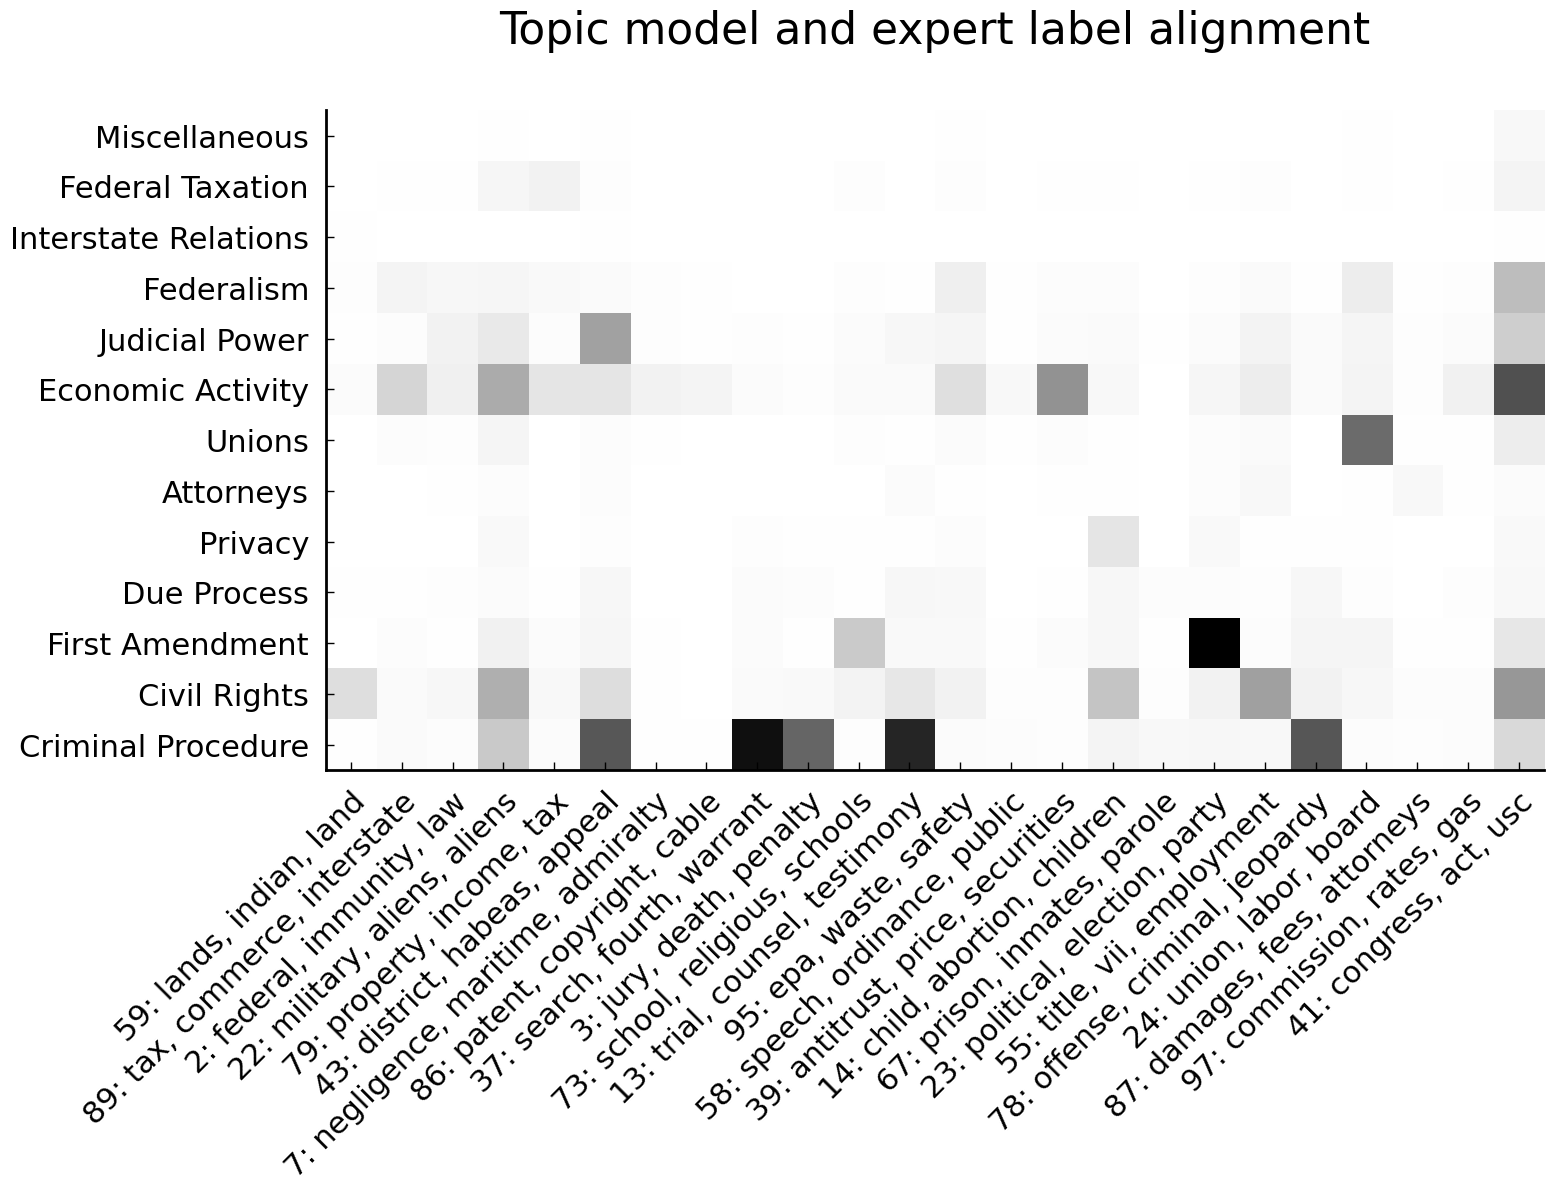

In [38]:
figure_3_topic_names = [f'Topic {t}' for _, t, _ in lauderdale_clark_figure_3_mapping]
df_plot = df_after_1945.groupby('issueArea')[figure_3_topic_names].sum()
df_plot = df_plot.rename(columns={
    f'Topic {t}': f'{t}: {figure_3_words}'
    for figure_3_words, t, _ in lauderdale_clark_figure_3_mapping
})
# heatmap code adapted from matplotlib documentation:
# https://matplotlib.org/gallery/images_contours_and_fields/
# image_annotated_heatmap.html

# `numpy.flipud` flips y-axis (to align with Lauderdale and Clark)
fig, ax = plt.subplots()
im = ax.imshow(np.flipud(df_plot.values), cmap="Greys")

ax.set_xticks(np.arange(len(df_plot.columns)))
ax.set_yticks(np.arange(len(df_plot.index)))
ax.set_xticklabels(df_plot.columns)
ax.set_yticklabels(reversed(df_plot.index))

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
ax.set_title('Topic model and expert label alignment')
fig.tight_layout()

<!-- Figure: Alignment between issue area labels and our topic model of Supreme Court opinions.\label{fig-topic-models-spaeth-heatmap} -->

For the most part, topics and Spaeth labels co-occur in an expected pattern. Topics which are associated with criminal procedure tend to co-occur with the Spaeth Criminal Procedure label. Topics associated with economic activity (Topics 79 and 39) tend to co-occur with the Economic Activity label. Words linked to Topic 24---which features words such as *union* and *labor*---tend to co-occur with the Spaeth label Unions. To the extent that we are persuaded that these patterns are unlikely to have arisen by chance, this visualization counts as an informal validation of the topic model.

Now we turn to a final illustration of the benefits of using a topic model: mixed-membership models of language are capable of capturing different word senses.

(sec-topic-models-polysemy)=
### Modeling different word senses

The formulation of the models in terms of latent distributions allows for the observation of specific words to "mean" something different in different contexts---just as a specific observation of an artwork's width can suddenly "mean" something different when one adds a height measurement that, in combination, makes the observation likely to come from a different latent distribution. Other methods used previously where mixed-membership models might have been used do not allow for modeling different <span class="index">word sense</span>s (sometimes called "<span class="index">polysemy</span>").

Let us work on a concrete example and look at how the mixed-membership model appears to capture the distinction between the word *minor* used as an adjective (e.g., "minor offense", "minor party") and *minor* used as a noun to refer to a child or adolescent. We can identify documents in which the word *minor* appears by finding documents which feature topic distributions which assign greatest probability to the word *minor*. The following block of code does just this. We first find the latent topic distributions which feature *minor* and then find several exemplary documents which feature the latent distributions.

In [39]:
minor_top_topics = topic_word_distributions['minor'].sort_values(ascending=False).head(5)

In [40]:
minor_top_topics_top_words = topic_word_distributions.loc[minor_top_topics.index].apply(
        lambda row: ', '.join(row.sort_values(ascending=False).head().index),
        axis=1,
)
minor_top_topics_top_words.name = 'topic_top_words'
minor_top_topics.to_frame().join(minor_top_topics_top_words)

minor                              topic_top_words
Topic 14  1392.510236      child, children, medical, health, women
Topic 50   714.482133            estate, death, wife, husband, mrs
Topic 40   349.211324      court, ante, justice, majority, dissent
Topic 44   232.288472        use, area, new, economic, substantial
Topic 78   221.881174  criminal, states, united, indictment, crime

Let's look at the text of a document which features the topic most strongly associated with the word "minor" (Topic 14). We will consider *Bowen v. Gillard* (483 US 587), a case which concerns a law regulating how financial support from the state for a child is (or is not) given to a parent. The following block of code confirms that the opinion does in fact feature one of the topics in which the word *minor* is prominent. A subsequent block shows a portion of the text of the opinion.

In [41]:
opinion_of_interest = ('483 US 587', 'brennan')
document_topic_distributions.loc[opinion_of_interest, minor_top_topics.index]

/usr/local/lib/python3.9/site-packages/pandas/core/indexing.py:925: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)


Topic 14  Topic 50  Topic 40  Topic 44  Topic 78
us_reports_citation authors                                                  
483 US 587          brennan  0.442462  0.017859  0.040139  0.092659  0.000003

In [42]:
print(df.loc[opinion_of_interest, 'text'].values[0][1000:2000])

ng personal behavior.  On certain occasions, however, government intrusion into private life is so direct and substantial that we must deem it intolerable if we are to be true to our belief that there is a boundary between the public citizen and the private person.
This is such a case.  The Government has told a child who lives with a mother receiving public assistance that it cannot both live with its mother and be supported by its father.  The child must either leave the care and custody of the mother, or forgo the support of the father and become a Government client. The child is put to this choice not because it seeks Government benefits for itself, but because of a fact over which it has no control: the need of other household members for public assistance. A child who lives with one parent has, under the best of circumstances, a difficult time sustaining a relationship with both its parents.  A crucial bond between a child and its parent outside the home, usually the father, is t

/usr/local/lib/python3.9/site-packages/pandas/core/indexing.py:925: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)


Note that this case features prominently in the latent distribution (Topic 14) which assigns the highest probability to *minor* of any of the latent distributions. Now let us look at a decision which happens to feature the word *minor* more than 20 times but which is associated with a *different* topic than the one featured in Justice Byron White's opinion in *Bowen v. Gillard*. The following blocks of code confirm that the word *minor* is indeed frequent in the opinion and show the mixing weights associated with several latent distributions.

In [43]:
opinion_of_interest = ('479 US 189', 'white_b')
print(f'"minor" count in 479 US 189:', sum('minor' in word.lower()
          for word in df.loc[opinion_of_interest, 'text'].values[0].split()))

"minor" count in 479 US 189: 21


In [44]:
document_topic_distributions.loc[opinion_of_interest, minor_top_topics.index.tolist() + ['Topic 23']]

Topic 14  Topic 50  Topic 40  Topic 44  Topic 78  \
us_reports_citation authors                                                     
479 US 189          white_b  0.023406  0.000007  0.115436  0.038544  0.000007   

                             Topic 23  
us_reports_citation authors            
479 US 189          white_b  0.149759

This opinion is far more strongly associated with Topic 23 than with Topic 14. The word *minor* is modeled as being associated with a topic which assigns high probability to words which have very little to do with children and everything to do with political parties and electoral competition. The following block of code shows some of the words most strongly associated with Topic 23.

In [45]:
topic_oi = 'Topic 23'
topic_oi_words = ', '.join(
    topic_word_distributions.loc[topic_oi].sort_values(ascending=False).head(8).index)
print(f'Topic 23 top words:\n  {topic_oi_words}')

Topic 23 top words:
  speech, amendment, government, political, party, press, freedom, free


The following block of code further inspects the full text of this particular opinion. We can see that *minor* is used here as an adjective.

In [46]:
print(df.loc[opinion_of_interest, 'text'][0][1000:1500])

held on the same day as the primary election for "major" parties. 1 The convention-nominated, minor-party candidate secured a position on the general election ballot upon the filing of a certificate signed by at least 100 registered voters who had participated in the convention and who had not voted in the primary election. 2  The 1977 amendments retained the requirement that a minor-party candidate be nominated by convention, 3 but imposed the additional requirement that, as a precondition to g


/usr/local/lib/python3.9/site-packages/pandas/core/indexing.py:925: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)


As we can tell whether or not *minor* is used as an adjective or noun by inspecting words which surround the word, we verify that all the uses of the word *minor* in this opinion are indeed adjectival:

In [47]:
import itertools

opinion_text = df.loc[opinion_of_interest, 'text'][0]
window_width, num_words = 3, len(opinion_text.split())
words = iter(opinion_text.split())
windows = [
    ' '.join(itertools.islice(words, 0, window_width))
    for _ in range(num_words // window_width)
]
print([window for window in windows if 'minor' in window])

['a minor-party candidate', 'candidates from minor', 'amendments, a minor-party', 'minor-party candidate secured', 'that a minor-party', 'a minor-party or', 'and minor-party candidates,', 'candidates of minor', 'minor parties who', 'number of minor', 'minor parties having', 'virtually every minor-party', 'of 12 minor-party', 'minor-party ballot access.', 'that minor parties', 'about how minor', "minor party's qualification", 'primary," minor-party candidates', 'which minor-party candidates', 'a minor-party candidate']


Having superficially checked the suitability of the mixed-membership model as a model of our corpus and having reviewed the capacity of topic models to capture---at least to some extent---differences in word senses, we will now put the model to work in modeling trends visible in the Supreme Court corpus.

(sec-topic-models-exploring-trends)=
### Exploring trends over time in the Supreme Court

The opinions in the corpus were written over a considerable time frame. In addition to being associated with mixing weights, each opinion is associated with a year, the year in which the opinion was published. Having the year of publication associated with each opinion allows us to gather together all the opinions published in a given year and calculate how frequently words associated with each latent topic distribution appear. As we will see, the rise and fall of the prevalence of specific latent distributions appears to track the prominence of legal issues associated with words linked to the distributions.

We began this chapter with one example of a <span class="index">trend</span>---an increasing rate of cases related to race and education---and we will offer an additional example here. Figure {ref}`fig-topic-models-discrimination-topic` at the beginning of this chapter showed the proportion of all words in all opinions that year related to a "topic" characterized, in a sense which is now clear, by words such as *school*, *race*, *voting*, *education*, and *minority*. That is, these words are among the most probable words under the latent topic distribution.

In this section we will consider a different <span class="index">trend</span> which the model appears able to capture. This trend tracks the rise of laws regulating labor union activity since the 1930s and the associated challenges to these laws which yield Supreme Court opinions. Prior to the 1930s, the self-organization of employees into labor unions for the purpose of, say, protesting dangerous or deadly working conditions faced considerable and sometimes unsurmountable obstacles. In this period, capitalist firms were often able to to enlist the judiciary and the government to prevent workers from organizing. Legislation passed in the 1930s created a legal framework for worker organizations out of which modern labor law emerged.

Likely because labor law is anchored in laws passed during a short stretch of time (the 1930s), it is a particularly well-defined body of law and our mixed-membership model is able to identify our two desired items: a cluster of semantically related words linked to labor law and document-specific proportions of words associated with this cluster. In our model, the latent distribution is Topic 24 and it is clear from inspecting the top 10 words most strongly associated with the latent distribution that it does indeed pick out a set of semantically related words connected to workers' organizations:

In [48]:
labor_topic = 'Topic 24'
topic_word_distributions.loc[labor_topic].sort_values(ascending=False).head(10)

board         23593.337446
union         22111.377863
labor         16687.690239
employees      9523.078246
bargaining     7999.962729
act            6221.954100
employer       5935.989537
collective     5838.038565
agreement      4569.440541
relations      3802.370509
Name: Topic 24, dtype: float64

As it will be useful in a moment to refer to this constellation of top words by a human-readable label rather than an opaque number (e.g., "Topic 24"), we will concatenate the top words into a string (``topic_top_words_joined``) which we can use as an improvised label for the latent distribution.

In [49]:
topic_top_words = topic_word_distributions.loc[labor_topic].sort_values(
    ascending=False).head(10).index
topic_top_words_joined = ', '.join(topic_top_words)
print(topic_top_words_joined)

board, union, labor, employees, bargaining, act, employer, collective, agreement, relations


Before we can plot the prevalence of words associated with this semantic constellation we
need to decide on what we mean by "prevalence". This question is a conceptual question
which has little to do with mixed-membership models as such and everything to do with
measuring the presence of a continuous feature associated with elements in a population.
Our mixed-membership model gives us measurements of the mixing weights---technically
speaking, point estimates of parameters---interpretable as the estimated *proportion* of
words associated with latent distributions in a single opinion. Taken by itself, this
proportion does not capture information about the length of an opinion. And we might
reasonably expect to distinguish between a 14,000-word opinion in which 50% of the words
are associated with a topic and an opinion which is 500 words and has the same proportion
associated with the topic.

```{margin}
There are some alternative statistics which one might reasonably want to consider. For example, the maximum proportion of words associated with a given topic would potentially measure the "peak attention" any judge gave to the topic in an opinion.
```
Our recommended solution here is to take account of document length by plotting, for each year, the proportion of all words in all opinions associated with a given topic. We can, in effect, calculate the total number of words in all opinions published in a given year associated with a topic by multiplying opinion lengths by the estimated topic shares. Finally, to make years with different numbers of opinions comparable, we can divide this number by the total number of words in opinions from that year.

In [50]:
# convert `dtm` (matrix) into an array:
opinion_word_counts = np.array(dtm.sum(axis=1)).ravel()
word_counts_by_year = pd.Series(opinion_word_counts).groupby(df.year.values).sum()
topic_word_counts = document_topic_distributions.multiply(opinion_word_counts,
                                                          axis='index')
topic_word_counts_by_year = topic_word_counts.groupby(df.year.values).sum()
topic_proportion_by_year = topic_word_counts_by_year.divide(word_counts_by_year,
                                                            axis='index')

In [51]:
topic_proportion_by_year.head()

Topic 0   Topic 1   Topic 2   Topic 3   Topic 4   Topic 5   Topic 6  \
1794  0.000038  0.019573  0.000038  0.000038  0.021096  0.000038  0.000038   
1795  0.000026  0.014169  0.000026  0.000026  0.025628  0.000026  0.000026   
1796  0.000028  0.036382  0.000028  0.000028  0.004396  0.032959  0.000028   
1797  0.000026  0.015645  0.000026  0.000026  0.010891  0.098829  0.000026   
1798  0.000352  0.009832  0.003496  0.001023  0.002399  0.121964  0.000010   

       Topic 7   Topic 8   Topic 9  ...  Topic 90  Topic 91  Topic 92  \
1794  0.013707  0.000038  0.000038  ...  0.000038  0.000038  0.000038   
1795  0.106625  0.000026  0.000026  ...  0.000026  0.000026  0.000026   
1796  0.021983  0.009850  0.000028  ...  0.000028  0.015842  0.000028   
1797  0.081282  0.000026  0.000026  ...  0.000026  0.007088  0.011393   
1798  0.000010  0.000010  0.000981  ...  0.051774  0.013590  0.002891   

      Topic 93  Topic 94  Topic 95  Topic 96  Topic 97  Topic 98  Topic 99  
1794  0.210499  0.002054  0.000038  0.000038  0.000038  0.000038  0.000038  
1795  0.000026  0.000026  0.000026  0.000026  0.000026  0.000026  0.000026  
1796  0.130444  0.002253  0.000028  0.000028  0.004262  0.000028  0.000028  
1797  0.083118  0.000026  0.000026  0.000026  0.002262  0.000026  0.000026  
1798  0.075408  0.000010  0.000010  0.000010  0.002979  0.000010  0.000010  

[5 rows x 100 columns]

As a final step, we will take the three-year <span class="index">moving average</span> of this measure to account for the fact that cases are heard by the Supreme Court irregularly. Because the Court only hears a limited number of cases each year, the absence of a case related to a given area of law in one or two years can happen by chance; an absence over more than three years is, by contrast, more likely to be meaningful. A three-year moving average of our statistic allows us to smooth over aleatory absences. (Moving averages are discussed in chapter {ref}`chp-working-with-data`.) Finally, we restrict our attention to the period after 1900 as the practices of the early Supreme Court tended to be considerably more variable than they are today.

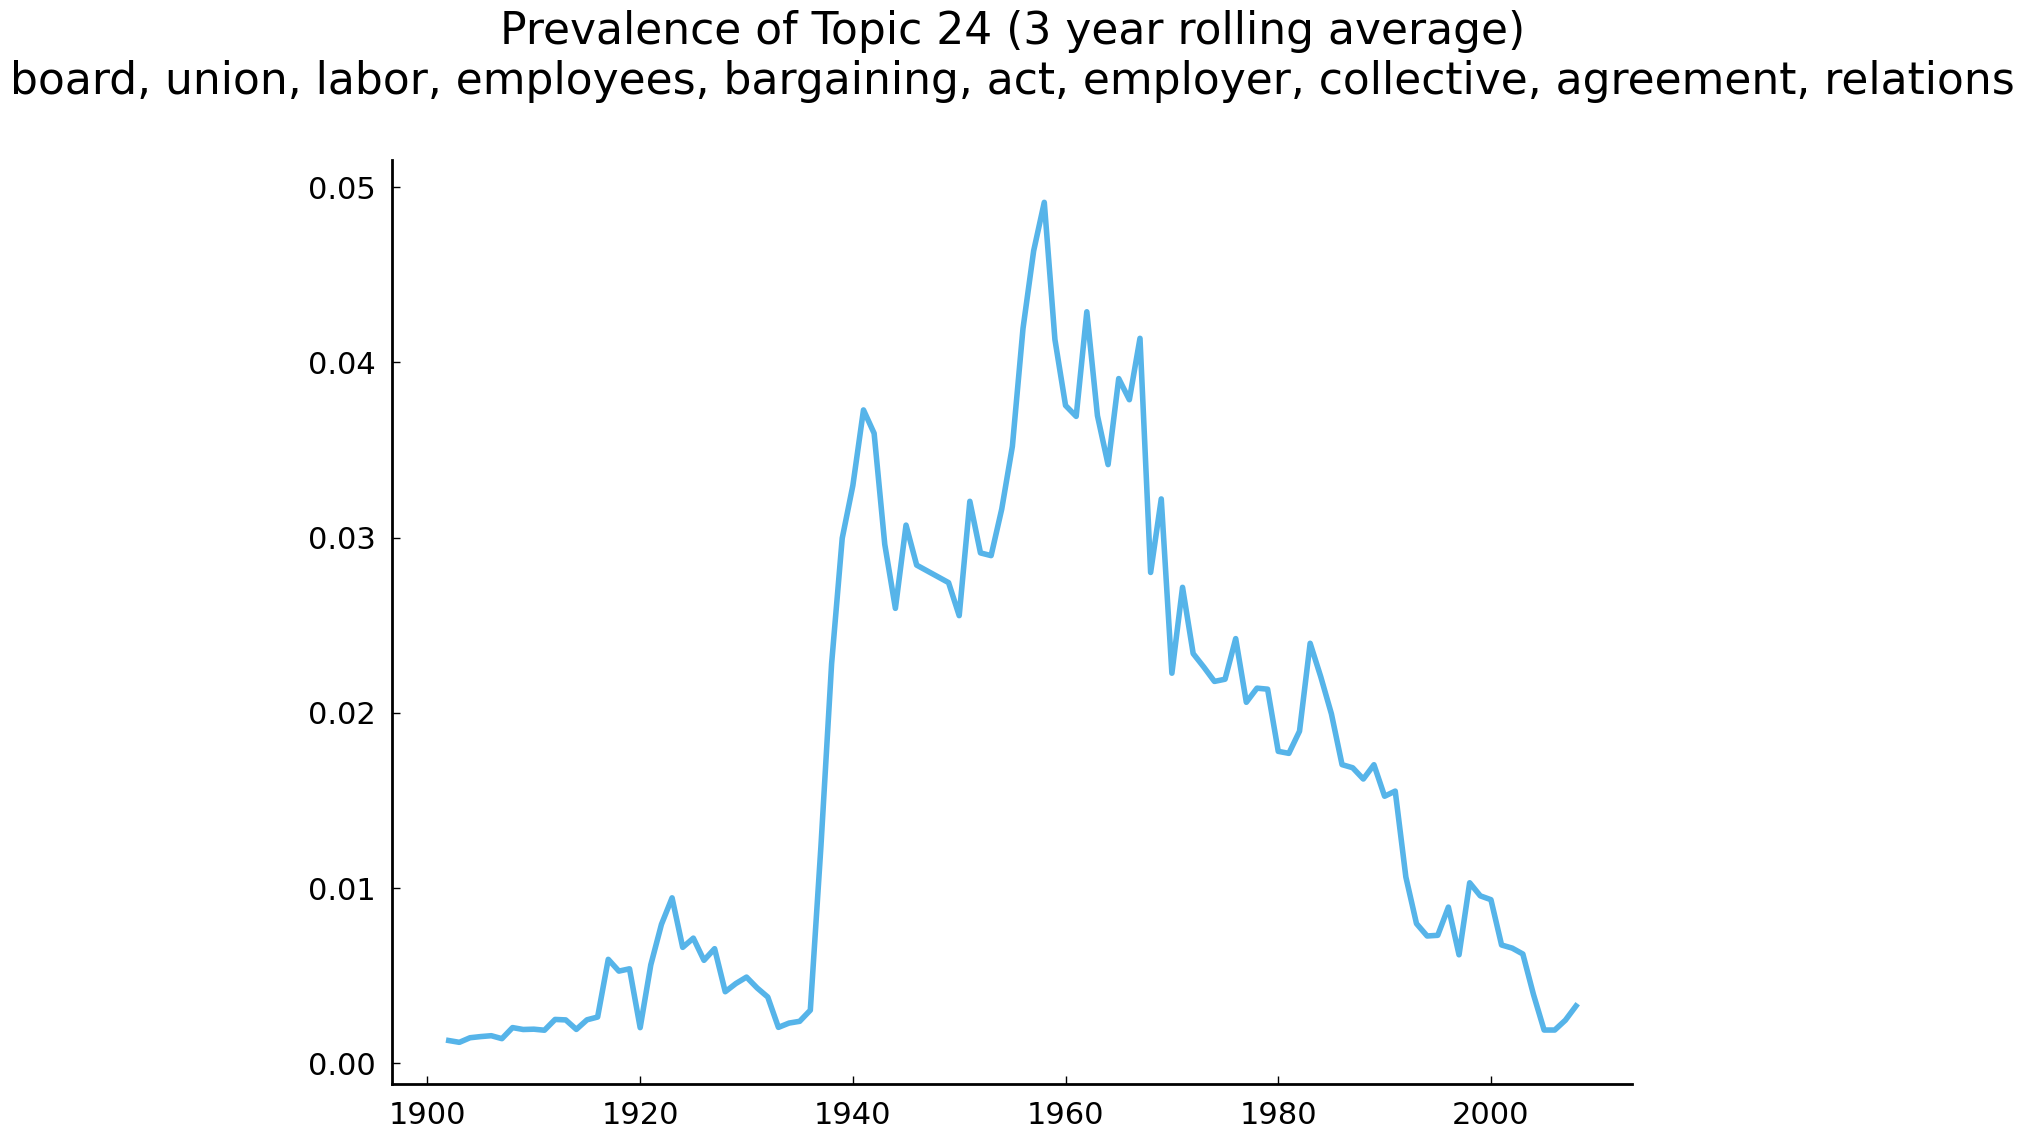

In [52]:
import matplotlib.pyplot as plt

window = 3
topic_proportion_rolling = topic_proportion_by_year.loc[1900:, labor_topic].rolling(
    window=window).mean()
topic_proportion_rolling.plot()
plt.title(f'Prevalence of {labor_topic} ({window} year rolling average)'
          f'\n{topic_top_words_joined}');

<!-- Figure: Prevalence of Topic 23 (3 year rolling average).\label{fig-topic-models-topic-24-prevalence} -->

The figure above shows the rise of decisions about the regulation of labor union activity. As mentioned earlier, prior to the 1930s, the self-organization of employees into labor unions for the purpose of, say, protesting dangerous working conditions faced considerable obstacles. In this period, employers were typically able to recruit the judiciary and the government into criminalizing workers' efforts to organize themselves into unions. One well-known example of this is from May 1894, when the railroad corporations enlisted the government to dispatch the military to stop workers associated with the American Railway Union (ARU) from striking. The pretext for deploying the army in support of the railroad corporations rested on a ruling by judges in the federal courts ({cite:t}`schneirov1999pullman`, 8--9). In addition to the threat of physical violence from the military, workers encountered other obstacles. Firms faced no restrictions if they wished to fire unionized employees who engaged in strikes over dangerous labor conditions. Employers were also allowed to require that workers, as a condition of employment, agree not to join a union (a "yellow-dog contract"). Prior to the 1930s, United States courts sided with employers and enforced these contracts ({cite:t}`gourevitch2016quitting`, 311). The 1930s and subsequent decades witnessed the passage of laws, notably the 1935 National Labor Relations Act, which limited some of the coercive tactics used by employers to prevent workers from negotiating for better working conditions. These and related laws were challenged in the courts. Many of these challenges were eventually heard by the Supreme Court. The figure above visualizes the yearly prevalence of these challenges and related discussions in the corpus of Supreme Court opinions.

While this narrative explanation for the trend observed in the parameters of the model may be persuasive, it is worth withholding judgment. Quantitative work in (cultural) history is littered with examples of "just-so stories" purporting to explain observed trends in data such as this ({cite:t}`lieberson:2000`, 77--81; {cite:t}`shalizi2011graphs`, 122--124). For this reason alone---and hopefully you have other reasons to be suspicious as well---we should demand some additional "validation" of the mixed-membership model. Unfortunately, the standard method for evaluating the effectiveness of a supervised model, out-of-sample predictive accuracy (i.e., validating the model on a held-out test set of the data), is typically not available when working with unsupervised models because there is no trusted set of "correct" labels (or agreed-upon labels) or values to be predicted. Checking unsupervised models, therefore, frequently requires creativity.

## Conclusion

Mixed-membership models of text offer one method of "reading" millions of
texts. While practicalities such as available computational resources often
restrict their use to modestly sized corpora such as the opinions corpus used
here, corpora of roughly this size (less than 100,000 documents) are common in
the humanities and interpretive social sciences.

Precisely because they do not rely on costly and difficult-to-replicate expert
labels, unsupervised models such as mixture and mixed-membership models provide
a useful method for capturing the trends in a large text corpus. This sort of
exploratory data analysis often generate insights which, in turn, lead to more
focused, hypothesis-driven investigations.  Gaining an awareness of the themes
and trends in the corpus as a whole can also provide useful context for
encounters with individual texts, giving the reader a sense of where an
individual document fits within the larger population of texts.

The standard topic model is just one example of an unsupervised model of text.
There are countless others. The basic building blocks of mixed-membership
models can be rearranged and connected to models of other available data such
as authorship {cite:p}`rosen2010learning`, relationships among authors
{cite:p}`krafft2012topicpartitioned`, and other document metadata
{cite:p}`gerrish2012how,zhao2017metalda`.  By incorporating side information
researchers believe is relevant, these models can provide the starting point
for further, alternative "readings" of large text corpora.

## Further Reading

Mixture models and mixed-membership models tend not to feature in introductory texts in statistics and machine learning. Readers interested in learning more about them will find their task easier if they are already well-versed in Bayesian statistics (see, for example, {cite:t}`hoff2009first` or {cite:t}`lee2012bayesian`). {cite:t}`bishop2007pattern` covers mixture models in chapter 9. {cite:t}`murphy2012machine` addresses mixture models in chapter 11 and discusses LDA specifically in chapter 27. Those interested in digging into the details of LDA should consult two remarkably complete technical reports: {cite:t}`heinrich2009parameter` and {cite:t}`carpenter2010integrating`.

Research articles in the humanities and interpretive social sciences which feature the use
of topic models include
{cite:t}`block2011what,mimno2012computational,riddell2014how,schoech2017topic`.
{cite:t}`chaney2012visualizing` discusses strategies for visualizing topic models.
{cite:t}`schofield2017pulling` and {cite:t}`schofield2016comparing` consider how stemming
and stop word removal influence the final fitted model.

## Exercises
The *Proceedings of the Old Bailey*, 1674--1913, include almost 200,000 transcriptions of
criminal trials that have taken place in London's central court. The *Old Bailey Corpus
2.0* is a balanced subset of the *Proceedings*, which was compiled and formatted by the
University of Saarland ({cite:t}`huber:2016`; see {cite:t}`huber:2007` for more information). It consists of
637 proceedings (files) in TEI-compliant XML, and amounts to approximately 24 million
words. In the following exercises, we will explore (a subset of) the corpus using topic
models. A simplified CSV version of the corpus can be found under
`data/old-bailey.csv.gz`. This CSV file contains the following five columns: (i) the `id` of
each trial, (ii) the transcription of the trail (`text`), (iii) the category of the
`offence`, (iv) the `verdict`, and (v), the `date` of the trial.

### Easy
1. First, load the corpus using Pandas, and ensure that you parse the `date` column as
   Python `datetime` objects. Then, select a subset of the corpus consisting of trial
   dates between 1800 and 1900.
2. Before running a topic model, it is important to first get a better understanding of
   the structure of the collection under scrutiny. Answer the following four questions:
   1. How many documents are there in the subset?
   2. How many trials resulted in a "guilty" verdict?
   3. What is the most frequent offence category?
   4. In which month(s) of the year on did most court cases take place?
3. We now continue with training a mixed-membership model for the collection. 
   1. First, construct a document-term matrix for the collection using scikit-learn's
      `Countvectorizer`. Pay close attention to the different parameters of the vectorizer,
      and motivate your choices.
   2. Use scikit-learn's `LatenDirichletAllocation` class to estimate the parameters of a
      mixed-membership model. Think about the number of components (i.e., topics) you
      consider necessary. After initializing the class, fit the model and transform the
      document-term matrix into a document-topic distribution matrix. 
   3. Create two Pandas `DataFrame` objects, one holding the topic-word distributions
      (with the topics as index and the vocabulary as columns), and
      the other holding the document-topic distributions (with the topics as columns and
      the index of the corpus as index). Verify that the shapes of both data frames are
      correct.

### Moderate
1. Look up the topic distribution of trial `t18680406-385`. Which topics feature
   prominently in this transcription? To which words do these topics assign relatively
   high probability? Do the topics provide a good summary of the actual contents of the
   transcription? 
2. To further assess the quality of the mixed-membership model, create a "rank abundance"
   curve plot for the latent topic distributions of eight randomly chosen trials in the
   data (cf. Section {ref}`sec-topic-models-parameter-estimation`). Describe the shape of the
   document-specific mixing weights. Why aren't the weights distributed uniformly?
3. Most trials provide information about the offence. In this exercise, we will invesigate
   the relation between the topic distributions and the offence. Compute the average topic
   distribution for each unique offence label. Use Matplotlib's `imshow` to plot the
   resulting matrix. Add appropriate labels (i.e., offence labels and topic labels) to the
   axes. Comment on your results.

### Challenging
Topic models are sometimes used as a form of dimensionality reduction, in a manner
resembling the way Principal Component Analysis (PCA) is used. Recall from Chapter
{ref}`chp-stylometry` that a PCA analysis of corpus with $N$ documents using the first $K$
principal components produces a decomposition of a document-term matrix of counts which
superficially resembles a topic model's decomposition of the same matrix: both take a
sparse matrix of counts and produce, among other outputs, a dense matrix which describes
each of the $N$ documents using $K$ values. In the case of the topic model, the dense
matrix contains point estimates of the $N$ document-topic distributions. In the case of
PCA, the dense matrix contains $N$ component scores, each of length $K$.  The
interpretation of each matrix is different, of course. And the values themselves are
different. For example, each element of the document-topic matrix is non-negative and the
rows sum to 1.  Each matrix, however, seen as a "compressed" version of the original
matrix, can be put to work in a similar way. The exercise presented here considers using
the dense matrix---rather than the full matrix of counts---as an input to a supervised
classifier.

1. Compare the topic model's representation of the *Old Bailey Corpus* with the
   representation provided by PCA (use as many principal components as used in the topic
   model). If needed, go back to chapter {ref}`chp-stylometry` to learn how to do this with
   scikit-learn's `PCA` class, which has essentially the same interface as
   `LatentDirichletAllocation`.  Train a classifier provided by scikit-learn such as
   `KNeighborsClassifier` using 50% of the documents. Have the classifier predict the
   offence labels in the remaining 50% of opinions.
2. Assess the predictive performance of the classifier based on the document-topic
   distributions for each offence label separately (scikit-learn's `classification_report`
   in the `metrics` module might be useful here). Are there types of opinions which appear
   to be easier to predict than others?


(sec-topic-models-appendix)=
## Appendix: Mapping Between our Topic Model and Lauderdale and Clark (2014)

In [53]:
# each tuple records the following in the order used by Lauderdale and Clark:
# (<Lauderdale and Clark top words>, <our topic number>, <our top words>)
lauderdale_clark_figure_3_mapping = (
    ('lands, indian, land', 59, 'indian, territory, indians'),
    ('tax, commerce, interstate', 89, 'commerce, interstate, state'),
    ('federal, immunity, law', 2, 'suit, action, states, ..., immunity'),
    ('military, aliens, aliens', 22, '..., alien,..., aliens, ..., deportation, immigration'),
    ('property, income, tax', 79, 'tax, taxes, property'),
    ('district, habeas, appeal', 43, 'court, federal, district, appeals, review, courts, habeas'),
    ('negligence, maritime, admiralty', 7, 'vessel, ship, admiralty'),
    ('patent, copyright, cable', 86, 'patent, ..., invention, patents'),
    ('search, fourth, warrant', 37, 'search, warrant, fourth'),
    ('jury, death, penalty', 3, 'sentence, death, sentencing, penalty'),
    ('school, religious, schools', 73, 'religious, funds, ... government, ..., establishment'),
    ('trial, counsel, testimony', 13, 'counsel, trial, defendant'),
    ('epa, waste, safety', 95, 'regulations, ..., agency, ..., safety, ..., air, epa' ),
    ('speech, ordinance, public', 58, 'speech, amendment, .., public'),
    ('antitrust, price, securities', 39, 'market, price, competition, act, antitrust'),
    ('child, abortion, children', 14, 'child, children, medical, ..., woman, ... abortion'),
    ('prison, inmates, parole', 67, 'prison, release, custody, parole' ),
    ('political, election, party', 23, 'speech, amendment, ..., political, party'),
    ('title, vii, employment', 55, 'title, discrimination, ..., vii'),
    ('offense, criminal, jeopardy', 78, 'criminal, ..., crime, offense'),
    ('union, labor, board', 24, 'board, union, labor'),
    ('damages, fees, attorneys', 87, 'attorney, fees, ..., costs'),
    ('commission, rates, gas', 97, 'rate, ..., gas, ..., rates'),
    ('congress, act, usc', 41, 'federal, congress, act, law'),
)

In [54]:
# HIDE THIS CELL
# integrity check. We define this table in two places. The definitions must match.
import pickle
import hashlib
assert len(lauderdale_clark_figure_3_mapping) == 24, len(lauderdale_clark_figure_3_mapping)
assert hashlib.sha256(pickle.dumps(lauderdale_clark_figure_3_mapping)).hexdigest() == '02e57c243457f5bc7f06f2bffa6d1bac68cc32d537db29d5dc6519ee11726a16'

AssertionError: 

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


findfont: Generic family 'sans-serif' not found because none of the following families were found: "Roboto Condensed Regular"


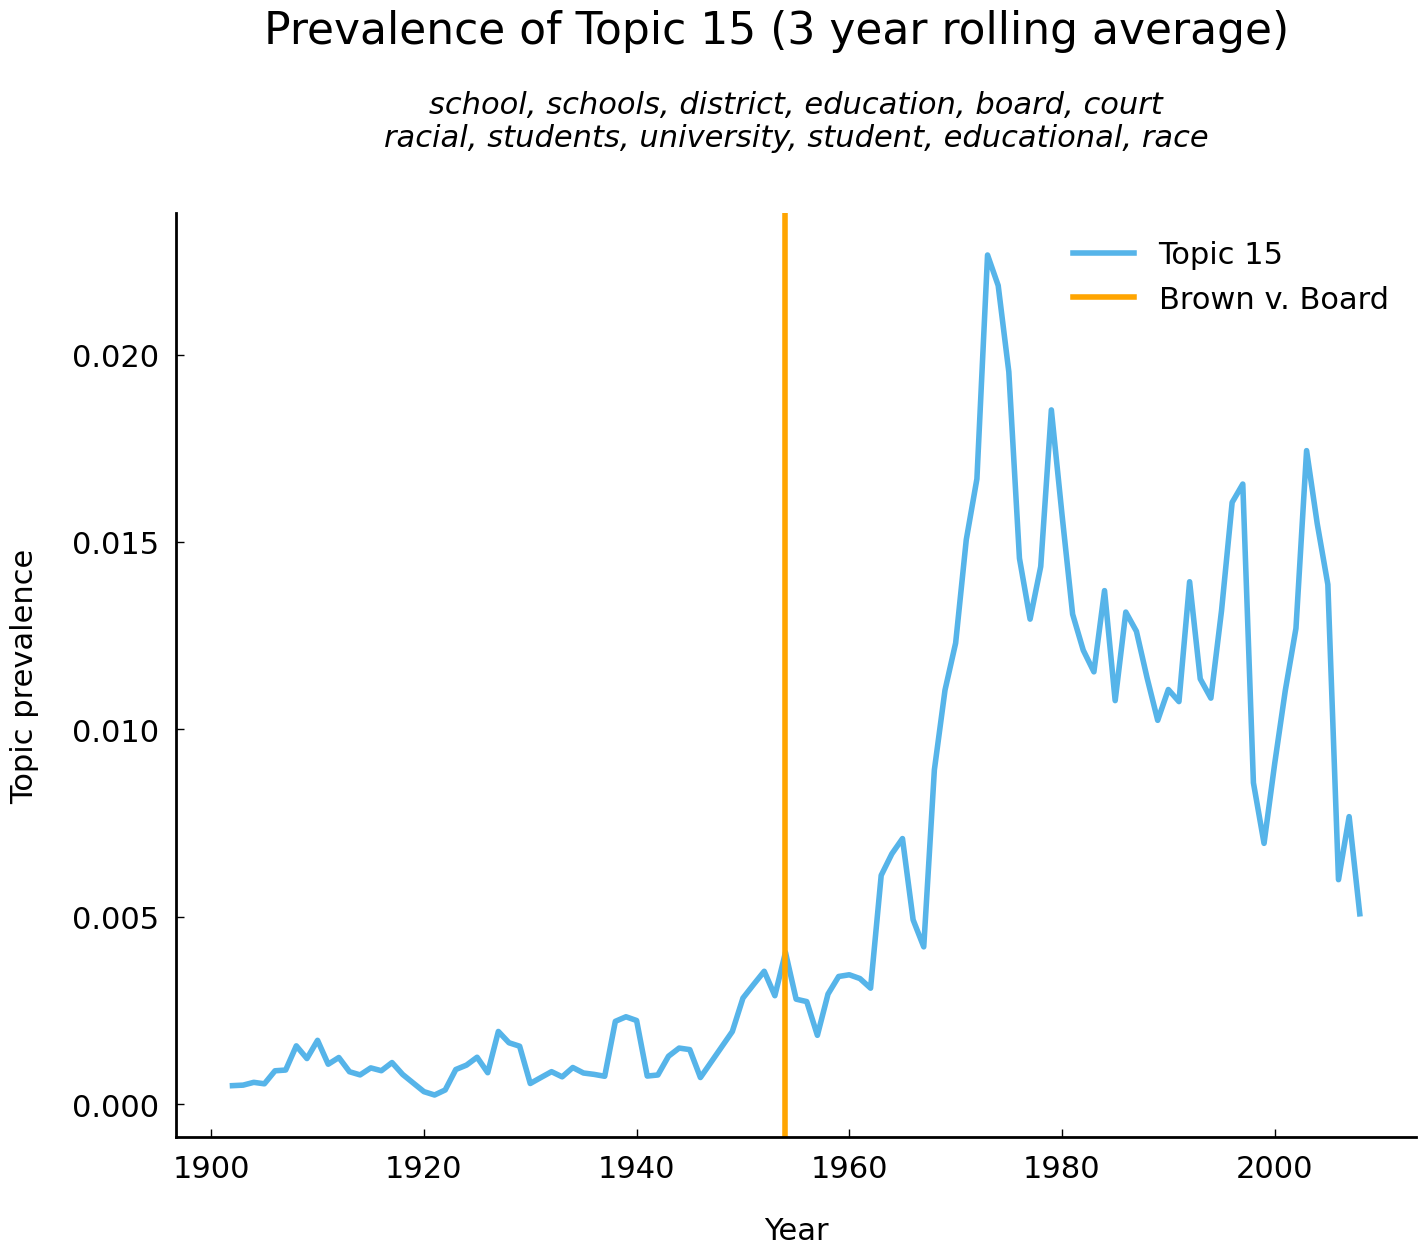

In [55]:
# HIDE THIS CELL (CODE TO CREATE PLOT AT BEGINNING OF CHAPTER)
import matplotlib.pyplot as plt
discrimination_topic = 'Topic 15'
topic_top_words = topic_word_distributions.loc[discrimination_topic].sort_values(ascending=False).head(12).index
topic_top_words_joined = f"{', '.join(topic_top_words[:6])}\n{', '.join(topic_top_words[6:])}"
window = 3
topic_proportion_by_year.loc[1900:, discrimination_topic].rolling(window=window).mean().plot()
plt.suptitle(f'Prevalence of {discrimination_topic} ({window} year rolling average)', y=1.05, fontsize='x-large')
plt.title(topic_top_words_joined, fontsize='medium', style='italic')
plt.axvline(x=1954, color='orange', label='Brown v. Board')
plt.ylabel("Topic prevalence")
plt.xlabel("Year")
plt.legend()
plt.savefig('figures/discrimination-topic.png')